## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## 量子化

In [2]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 

import optuna.integration.lightgbm as lgb # Optuna ハイパーパラメーター用
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import warnings
warnings.simplefilter('ignore')

In [3]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [5]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

In [6]:
# 目的変数
print(y_train.dtypes)

# 説明変数
display(pd.DataFrame(X_train_ce.dtypes).T)

float64


,Rank,Name,basename,Genre,ESRB_Rating_E,ESRB_Rating_T,ESRB_Rating_M,ESRB_Rating_E10,ESRB_Rating_EC,ESRB_Rating_RP,...,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Year,Last_Update,url,status,Vgchartzscore,img_url
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


[I 2021-12-27 16:28:41,700] A new study created in memory with name: no-name-f3318027-6728-4f6f-8408-d4bb864ea004


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:28:42,429] Trial 0 finished with value: 0.3412301298956539 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.3412301298956539.


Early stopping, best iteration is:
[39]	Train's rmse: 0.148039	Test's rmse: 0.34123
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:28:43,282] Trial 1 finished with value: 0.36319818283332056 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.3412301298956539.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119969	Test's rmse: 0.363198
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:28:44,229] Trial 2 finished with value: 0.35158111665403585 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.3412301298956539.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112125	Test's rmse: 0.351581
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:28:44,943] Trial 3 finished with value: 0.34334969762085965 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.3412301298956539.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153983	Test's rmse: 0.34335
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:28:45,888] Trial 4 finished with value: 0.3534894306752722 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.3412301298956539.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.107351	Test's rmse: 0.353489
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:28:46,696] Trial 5 finished with value: 0.35272197059535476 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.3412301298956539.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.105091	Test's rmse: 0.352722
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:28:47,528] Trial 6 finished with value: 0.3450742997835388 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.3412301298956539.


Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:28:49,535] Trial 7 finished with value: 0.34698791501872656 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.34698791501872656.


Early stopping, best iteration is:
[48]	Train's rmse: 0.146236	Test's rmse: 0.346988
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:28:53,854] Trial 8 finished with value: 0.34501221031012463 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.34501221031012463.


Early stopping, best iteration is:
[39]	Train's rmse: 0.144207	Test's rmse: 0.345012
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:28:58,280] Trial 9 finished with value: 0.34841347592852095 and parameters: {'num_leaves': 188}. Best is trial 8 with value: 0.34501221031012463.


Early stopping, best iteration is:
[48]	Train's rmse: 0.139693	Test's rmse: 0.348413
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:04,722] Trial 10 finished with value: 0.3442043038040037 and parameters: {'num_leaves': 154}. Best is trial 10 with value: 0.3442043038040037.


Early stopping, best iteration is:
[48]	Train's rmse: 0.141445	Test's rmse: 0.344204
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:06,192] Trial 11 finished with value: 0.3408754905505668 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.3408754905505668.


Early stopping, best iteration is:
[47]	Train's rmse: 0.14333	Test's rmse: 0.340875
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:07,672] Trial 12 finished with value: 0.3408754905505668 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.3408754905505668.


Early stopping, best iteration is:
[47]	Train's rmse: 0.14333	Test's rmse: 0.340875
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:08,717] Trial 13 finished with value: 0.34183693604171 and parameters: {'num_leaves': 16}. Best is trial 11 with value: 0.3408754905505668.


Early stopping, best iteration is:
[48]	Train's rmse: 0.144045	Test's rmse: 0.341837
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:16,156] Trial 14 finished with value: 0.34868652761646113 and parameters: {'num_leaves': 222}. Best is trial 11 with value: 0.3408754905505668.


Early stopping, best iteration is:
[37]	Train's rmse: 0.149145	Test's rmse: 0.348687
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:18,811] Trial 15 finished with value: 0.3442963064423202 and parameters: {'num_leaves': 155}. Best is trial 11 with value: 0.3408754905505668.


Early stopping, best iteration is:
[37]	Train's rmse: 0.149202	Test's rmse: 0.344296
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:21,188] Trial 16 finished with value: 0.3471931791127858 and parameters: {'num_leaves': 182}. Best is trial 11 with value: 0.3408754905505668.


Early stopping, best iteration is:
[48]	Train's rmse: 0.142772	Test's rmse: 0.347193
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:22,695] Trial 17 finished with value: 0.34262018512614556 and parameters: {'num_leaves': 81}. Best is trial 11 with value: 0.3408754905505668.
[I 2021-12-27 16:29:22,808] Trial 18 finished with value: 0.3293648766510351 and parameters: {'num_leaves': 2}. Best is trial 18 with value: 0.3293648766510351.


Early stopping, best iteration is:
[48]	Train's rmse: 0.142382	Test's rmse: 0.34262
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181922	Test's rmse: 0.329365
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:22,945] Trial 19 finished with value: 0.3286306115870888 and parameters: {'num_leaves': 3}. Best is trial 19 with value: 0.3286306115870888.
[I 2021-12-27 16:29:23,080] Trial 20 finished with value: 0.3354492525890436 and parameters: {'num_leaves': 4}. Best is trial 19 with value: 0.3286306115870888.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174981	Test's rmse: 0.328631
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152301	Test's rmse: 0.335449
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:25,398] Trial 21 finished with value: 0.34664878626963624 and parameters: {'num_leaves': 83}. Best is trial 19 with value: 0.3286306115870888.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119631	Test's rmse: 0.346649
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:27,946] Trial 22 finished with value: 0.34586600244209326 and parameters: {'num_leaves': 46}. Best is trial 19 with value: 0.3286306115870888.


Early stopping, best iteration is:
[48]	Train's rmse: 0.141098	Test's rmse: 0.345866
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:32,534] Trial 23 finished with value: 0.34818320946460507 and parameters: {'num_leaves': 115}. Best is trial 19 with value: 0.3286306115870888.


Early stopping, best iteration is:
[48]	Train's rmse: 0.141996	Test's rmse: 0.348183
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:34,519] Trial 24 finished with value: 0.3464759502417622 and parameters: {'num_leaves': 62}. Best is trial 19 with value: 0.3286306115870888.


Early stopping, best iteration is:
[37]	Train's rmse: 0.150048	Test's rmse: 0.346476
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:34,874] Trial 25 finished with value: 0.3274649076068678 and parameters: {'num_leaves': 6}. Best is trial 25 with value: 0.3274649076068678.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124266	Test's rmse: 0.327465
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:35,856] Trial 26 finished with value: 0.3425709153766986 and parameters: {'num_leaves': 34}. Best is trial 25 with value: 0.3274649076068678.


Early stopping, best iteration is:
[48]	Train's rmse: 0.143068	Test's rmse: 0.342571
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:36,202] Trial 27 finished with value: 0.32763688940909574 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.32763688940909574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152501	Test's rmse: 0.327637
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:36,594] Trial 28 finished with value: 0.3266810719929008 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.3266810719929008.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134669	Test's rmse: 0.326681
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:36,920] Trial 29 finished with value: 0.3282633468639717 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.3266810719929008.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.158224	Test's rmse: 0.328263
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:37,229] Trial 30 finished with value: 0.3195455553703406 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 30 with value: 0.3195455553703406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169663	Test's rmse: 0.319546
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:37,558] Trial 31 finished with value: 0.3318294803491147 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 30 with value: 0.3195455553703406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148722	Test's rmse: 0.331829
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:37,876] Trial 32 finished with value: 0.3239834919135703 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 30 with value: 0.3195455553703406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173318	Test's rmse: 0.323983
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:38,225] Trial 33 finished with value: 0.34190923064574247 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 30 with value: 0.3195455553703406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128822	Test's rmse: 0.341909
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:38,565] Trial 34 finished with value: 0.32222397583687484 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 30 with value: 0.3195455553703406.


Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.158809	Test's rmse: 0.322224
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:39,011] Trial 35 finished with value: 0.3334557895665265 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 30 with value: 0.3195455553703406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159763	Test's rmse: 0.333456
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:39,341] Trial 36 finished with value: 0.3228663706188528 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 30 with value: 0.3195455553703406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157669	Test's rmse: 0.322866
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:39,671] Trial 37 finished with value: 0.3212166926752204 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.3212166926752204.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16906	Test's rmse: 0.321217
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:40,017] Trial 38 finished with value: 0.32422719408481593 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.3212166926752204.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16966	Test's rmse: 0.324227
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:40,371] Trial 39 finished with value: 0.3205098079781086 and parameters: {'feature_fraction': 0.852}. Best is trial 39 with value: 0.3205098079781086.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169627	Test's rmse: 0.32051
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:40,722] Trial 40 finished with value: 0.31987601794564924 and parameters: {'feature_fraction': 0.948}. Best is trial 40 with value: 0.31987601794564924.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170298	Test's rmse: 0.319876
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:41,079] Trial 41 finished with value: 0.3195455553703406 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 41 with value: 0.3195455553703406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169663	Test's rmse: 0.319546
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:41,410] Trial 42 finished with value: 0.3205098079781086 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 41 with value: 0.3195455553703406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169627	Test's rmse: 0.32051
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:41,744] Trial 43 finished with value: 0.322839342777967 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.322839342777967.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171328	Test's rmse: 0.322839
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:42,088] Trial 44 finished with value: 0.3187521646356465 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169711	Test's rmse: 0.318752
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:42,439] Trial 45 finished with value: 0.31954555604501145 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169663	Test's rmse: 0.319546
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:42,766] Trial 46 finished with value: 0.32287866928986925 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167709	Test's rmse: 0.322879
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:43,121] Trial 47 finished with value: 0.318760527295811 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169962	Test's rmse: 0.318761
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:43,556] Trial 48 finished with value: 0.3248834724580455 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171152	Test's rmse: 0.324883
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:43,917] Trial 49 finished with value: 0.3247835055769599 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168672	Test's rmse: 0.324784
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:44,295] Trial 50 finished with value: 0.31954555648161775 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169663	Test's rmse: 0.319546
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:44,600] Trial 51 finished with value: 0.31954596103271915 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169664	Test's rmse: 0.319546
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:45,001] Trial 52 finished with value: 0.31954569582848774 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169663	Test's rmse: 0.319546
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:45,367] Trial 53 finished with value: 0.33580653978281166 and parameters: {'lambda_l1': 5.402896923508629, 'lambda_l2': 0.00018194741639177489}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166476	Test's rmse: 0.335807
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:45,715] Trial 54 finished with value: 0.3189037070704441 and parameters: {'lambda_l1': 0.017510612865399015, 'lambda_l2': 0.019579349231545296}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169674	Test's rmse: 0.318904
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:46,156] Trial 55 finished with value: 0.3187608142754889 and parameters: {'lambda_l1': 0.005764962972197511, 'lambda_l2': 0.016301353379407572}. Best is trial 44 with value: 0.3187521646356465.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169959	Test's rmse: 0.318761
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:46,516] Trial 56 finished with value: 0.3187493902919931 and parameters: {'lambda_l1': 0.003665886855738534, 'lambda_l2': 0.006683193169977182}. Best is trial 56 with value: 0.3187493902919931.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169949	Test's rmse: 0.318749
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:46,896] Trial 57 finished with value: 0.3203495542548444 and parameters: {'lambda_l1': 0.11289288985537732, 'lambda_l2': 0.00026460642332250945}. Best is trial 56 with value: 0.3187493902919931.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170175	Test's rmse: 0.32035
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:47,248] Trial 58 finished with value: 0.31954844084251444 and parameters: {'lambda_l1': 0.0017339244329852821, 'lambda_l2': 1.940236383102938e-05}. Best is trial 56 with value: 0.3187493902919931.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169688	Test's rmse: 0.319548
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:47,621] Trial 59 finished with value: 0.3267194998799933 and parameters: {'lambda_l1': 1.2724755776699341, 'lambda_l2': 0.004046685677994383}. Best is trial 56 with value: 0.3187493902919931.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16648	Test's rmse: 0.326719
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:47,970] Trial 60 finished with value: 0.31982421841320396 and parameters: {'lambda_l1': 0.045355247073346996, 'lambda_l2': 0.118760751687072}. Best is trial 56 with value: 0.3187493902919931.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169876	Test's rmse: 0.319824
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:48,293] Trial 61 finished with value: 0.31955432316508625 and parameters: {'lambda_l1': 0.0014441715954420051, 'lambda_l2': 0.0020176034957203955}. Best is trial 56 with value: 0.3187493902919931.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16969	Test's rmse: 0.319554
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:48,665] Trial 62 finished with value: 0.31954573117444907 and parameters: {'lambda_l1': 0.00021056403720229701, 'lambda_l2': 3.0785615192833e-05}. Best is trial 56 with value: 0.3187493902919931.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169687	Test's rmse: 0.319546
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:48,997] Trial 63 finished with value: 0.3634902156806219 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.3634902156806219.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.0951094	Test's rmse: 0.36349
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:49,320] Trial 64 finished with value: 0.33260439991089663 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.33260439991089663.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149263	Test's rmse: 0.332604
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:49,624] Trial 65 finished with value: 0.3779529044476799 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.33260439991089663.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.212062	Test's rmse: 0.377953
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:49,968] Trial 66 finished with value: 0.3948682061307872 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.33260439991089663.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.260792	Test's rmse: 0.394868
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:50,298] Trial 67 finished with value: 0.47009075504316344 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.33260439991089663.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.317639	Test's rmse: 0.470091


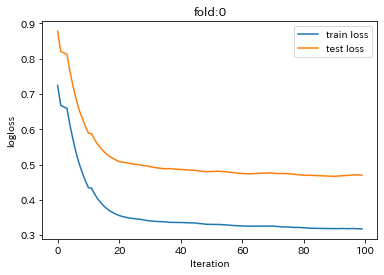

[I 2021-12-27 16:29:50,667] A new study created in memory with name: no-name-0b333d93-1269-4576-9d70-b36aeaae49d2


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:51,622] Trial 0 finished with value: 0.10313165674393071 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133798	Test's rmse: 0.103132
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:52,568] Trial 1 finished with value: 0.12250201339158852 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131693	Test's rmse: 0.122502
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:53,391] Trial 2 finished with value: 0.11199663372018692 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:54,288] Trial 3 finished with value: 0.10522738562850059 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144067	Test's rmse: 0.105227
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:55,258] Trial 4 finished with value: 0.13184108603175235 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136538	Test's rmse: 0.131841
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:56,233] Trial 5 finished with value: 0.10804926853338176 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134845	Test's rmse: 0.108049
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:29:57,441] Trial 6 finished with value: 0.11941999345239779 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130288	Test's rmse: 0.11942
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:02,112] Trial 7 finished with value: 0.10800532211248293 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.10800532211248293.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136362	Test's rmse: 0.108005
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:30:08,097] Trial 8 finished with value: 0.11777103450718834 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.10800532211248293.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137467	Test's rmse: 0.117771
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:13,222] Trial 9 finished with value: 0.11436902661139697 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.10800532211248293.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136702	Test's rmse: 0.114369
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:17,546] Trial 10 finished with value: 0.11429183581217504 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.10800532211248293.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136339	Test's rmse: 0.114292
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:19,949] Trial 11 finished with value: 0.10645611370855404 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.10645611370855404.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137238	Test's rmse: 0.106456
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:21,520] Trial 12 finished with value: 0.10645611370855404 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.10645611370855404.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137238	Test's rmse: 0.106456
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:22,460] Trial 13 finished with value: 0.10330247893938728 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.10330247893938728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134069	Test's rmse: 0.103302
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:33,021] Trial 14 finished with value: 0.11542609932374827 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.10330247893938728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13715	Test's rmse: 0.115426
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:36,032] Trial 15 finished with value: 0.11596803981774356 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.10330247893938728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135609	Test's rmse: 0.115968
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:39,026] Trial 16 finished with value: 0.11342893530789282 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.10330247893938728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136528	Test's rmse: 0.113429
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:39,574] Trial 17 finished with value: 0.11345922341111099 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.10330247893938728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141582	Test's rmse: 0.113459
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:43,218] Trial 18 finished with value: 0.10823665971363268 and parameters: {'num_leaves': 76}. Best is trial 13 with value: 0.10330247893938728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136596	Test's rmse: 0.108237
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:43,534] Trial 19 finished with value: 0.11788942523603016 and parameters: {'num_leaves': 3}. Best is trial 13 with value: 0.10330247893938728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.202714	Test's rmse: 0.117889
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:45,255] Trial 20 finished with value: 0.10708162122210671 and parameters: {'num_leaves': 57}. Best is trial 13 with value: 0.10330247893938728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136312	Test's rmse: 0.107082
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:47,903] Trial 21 finished with value: 0.11132230154414344 and parameters: {'num_leaves': 103}. Best is trial 13 with value: 0.10330247893938728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138482	Test's rmse: 0.111322
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:49,048] Trial 22 finished with value: 0.1061180101931124 and parameters: {'num_leaves': 37}. Best is trial 13 with value: 0.10330247893938728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13748	Test's rmse: 0.106118
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:50,014] Trial 23 finished with value: 0.10169827359096138 and parameters: {'num_leaves': 28}. Best is trial 23 with value: 0.10169827359096138.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139471	Test's rmse: 0.101698
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:52,928] Trial 24 finished with value: 0.1092607117115948 and parameters: {'num_leaves': 116}. Best is trial 23 with value: 0.10169827359096138.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138218	Test's rmse: 0.109261
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:54,812] Trial 25 finished with value: 0.10711690028748572 and parameters: {'num_leaves': 70}. Best is trial 23 with value: 0.10169827359096138.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13821	Test's rmse: 0.107117
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:55,319] Trial 26 finished with value: 0.10063744889159365 and parameters: {'num_leaves': 13}. Best is trial 26 with value: 0.10063744889159365.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136843	Test's rmse: 0.100637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:55,911] Trial 27 finished with value: 0.11303764730154461 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.11303764730154461.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.184443	Test's rmse: 0.113038
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:56,478] Trial 28 finished with value: 0.10815625888995063 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.10815625888995063.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158012	Test's rmse: 0.108156
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:56,962] Trial 29 finished with value: 0.11396181875734279 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.10815625888995063.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.187166	Test's rmse: 0.113962
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:57,391] Trial 30 finished with value: 0.12953143833342629 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.10815625888995063.


Early stopping, best iteration is:
[46]	Train's rmse: 0.213805	Test's rmse: 0.129531
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:57,872] Trial 31 finished with value: 0.11163024629119395 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.10815625888995063.


Early stopping, best iteration is:
[48]	Train's rmse: 0.186333	Test's rmse: 0.11163
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:58,332] Trial 32 finished with value: 0.11965908932965462 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.10815625888995063.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.191157	Test's rmse: 0.119659
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:59,085] Trial 33 finished with value: 0.1119603688517382 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 28 with value: 0.10815625888995063.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152332	Test's rmse: 0.11196
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:30:59,593] Trial 34 finished with value: 0.1134108008270075 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 28 with value: 0.10815625888995063.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.187672	Test's rmse: 0.113411
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:00,084] Trial 35 finished with value: 0.11716453051663145 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 28 with value: 0.10815625888995063.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.186218	Test's rmse: 0.117165
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:00,636] Trial 36 finished with value: 0.11114673382849828 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 28 with value: 0.10815625888995063.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175563	Test's rmse: 0.111147
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:01,101] Trial 37 finished with value: 0.10265726247655611 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.10265726247655611.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133261	Test's rmse: 0.102657
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:01,593] Trial 38 finished with value: 0.10553062512722085 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.10265726247655611.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136509	Test's rmse: 0.105531
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:02,061] Trial 39 finished with value: 0.10437985326140069 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.10265726247655611.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139801	Test's rmse: 0.10438
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:02,495] Trial 40 finished with value: 0.10063744889159365 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 40 with value: 0.10063744889159365.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136843	Test's rmse: 0.100637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:02,932] Trial 41 finished with value: 0.10437985326140069 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 40 with value: 0.10063744889159365.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139801	Test's rmse: 0.10438
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:03,371] Trial 42 finished with value: 0.10553062512722085 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 40 with value: 0.10063744889159365.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136509	Test's rmse: 0.105531
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:03,847] Trial 43 finished with value: 0.10869714813913231 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.10869714813913231.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140305	Test's rmse: 0.108697
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:04,294] Trial 44 finished with value: 0.10343015317196143 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.10343015317196143.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137587	Test's rmse: 0.10343
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:04,759] Trial 45 finished with value: 0.10063744906073636 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.10063744906073636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136843	Test's rmse: 0.100637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:05,254] Trial 46 finished with value: 0.09905595529504911 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138773	Test's rmse: 0.099056
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:05,705] Trial 47 finished with value: 0.1012426898778254 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1385	Test's rmse: 0.101243
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:06,166] Trial 48 finished with value: 0.1109843018402196 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147272	Test's rmse: 0.110984
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:06,659] Trial 49 finished with value: 0.1025591292544391 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138581	Test's rmse: 0.102559
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:07,137] Trial 50 finished with value: 0.10063744925542303 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136843	Test's rmse: 0.100637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:07,601] Trial 51 finished with value: 0.10387061376631437 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142408	Test's rmse: 0.103871
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:08,108] Trial 52 finished with value: 0.1006374876185027 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136843	Test's rmse: 0.100637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:08,617] Trial 53 finished with value: 0.11035255063251438 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.09866694315446872}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137467	Test's rmse: 0.110353
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:09,114] Trial 54 finished with value: 0.10063744890123998 and parameters: {'lambda_l1': 1.1692997958212103e-08, 'lambda_l2': 1.7001711861929543e-08}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136843	Test's rmse: 0.100637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:09,644] Trial 55 finished with value: 0.10063745062251273 and parameters: {'lambda_l1': 1.3512777353940762e-08, 'lambda_l2': 2.3120208094961207e-05}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136843	Test's rmse: 0.100637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:10,148] Trial 56 finished with value: 0.10063744916889124 and parameters: {'lambda_l1': 5.541518974002406e-07, 'lambda_l2': 2.35740695190084e-08}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136843	Test's rmse: 0.100637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:10,642] Trial 57 finished with value: 0.10387133129352381 and parameters: {'lambda_l1': 0.0013643656722816411, 'lambda_l2': 1.1508217261645661e-08}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142413	Test's rmse: 0.103871
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:11,152] Trial 58 finished with value: 0.10063745255530791 and parameters: {'lambda_l1': 1.1916519926516243e-08, 'lambda_l2': 4.624083095518924e-05}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136843	Test's rmse: 0.100637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:11,653] Trial 59 finished with value: 0.10385030474919564 and parameters: {'lambda_l1': 3.738425892816639e-06, 'lambda_l2': 0.1304964127901967}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138172	Test's rmse: 0.10385
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:12,176] Trial 60 finished with value: 0.10387119062410807 and parameters: {'lambda_l1': 1.8796187625037182e-07, 'lambda_l2': 0.0039440907858195725}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142413	Test's rmse: 0.103871
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:12,663] Trial 61 finished with value: 0.1038697243471768 and parameters: {'lambda_l1': 1.197340518782296e-07, 'lambda_l2': 0.5361615285304203}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136207	Test's rmse: 0.10387
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:13,155] Trial 62 finished with value: 0.10063745811722054 and parameters: {'lambda_l1': 2.528830125346676e-06, 'lambda_l2': 0.00010244181483444618}. Best is trial 46 with value: 0.09905595529504911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136843	Test's rmse: 0.100637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:13,619] Trial 63 finished with value: 0.09648545204547768 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.09648545204547768.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0783765	Test's rmse: 0.0964855
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:14,077] Trial 64 finished with value: 0.18641690559662388 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.09648545204547768.


Early stopping, best iteration is:
[34]	Train's rmse: 0.272614	Test's rmse: 0.186417
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:14,569] Trial 65 finished with value: 0.109670981993758 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.09648545204547768.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0412486	Test's rmse: 0.109671
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:15,079] Trial 66 finished with value: 0.11324022052002454 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.09648545204547768.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159253	Test's rmse: 0.11324
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:15,502] Trial 67 finished with value: 0.2292727286903095 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.09648545204547768.


Early stopping, best iteration is:
[29]	Train's rmse: 0.329491	Test's rmse: 0.229273


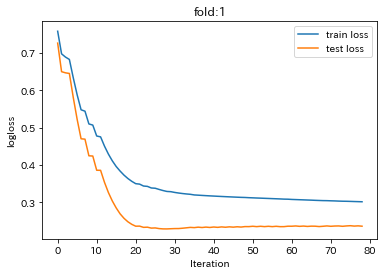

[I 2021-12-27 16:31:15,750] A new study created in memory with name: no-name-a63ba88a-dc53-46bc-9d96-e07ce9c1f36c


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:16,680] Trial 0 finished with value: 0.16902597277644246 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.16902597277644246.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134967	Test's rmse: 0.169026
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:17,507] Trial 1 finished with value: 0.14936328917663394 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.14936328917663394.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12905	Test's rmse: 0.149363
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:18,815] Trial 2 finished with value: 0.1399063359860016 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.1399063359860016.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14443	Test's rmse: 0.139906
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:20,023] Trial 3 finished with value: 0.14031536940373338 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.1399063359860016.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155903	Test's rmse: 0.140315
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:20,984] Trial 4 finished with value: 0.16057600609609454 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.1399063359860016.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129464	Test's rmse: 0.160576
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:21,803] Trial 5 finished with value: 0.1415026234343981 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.1399063359860016.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:22,673] Trial 6 finished with value: 0.1593121386019105 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.1399063359860016.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128939	Test's rmse: 0.159312
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:24,822] Trial 7 finished with value: 0.14379683451713518 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.14379683451713518.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1449	Test's rmse: 0.143797
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:29,837] Trial 8 finished with value: 0.14465859084418833 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.14379683451713518.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144616	Test's rmse: 0.144659
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:33,810] Trial 9 finished with value: 0.14312435810933832 and parameters: {'num_leaves': 188}. Best is trial 9 with value: 0.14312435810933832.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142317	Test's rmse: 0.143124
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:37,321] Trial 10 finished with value: 0.14547889837137531 and parameters: {'num_leaves': 154}. Best is trial 9 with value: 0.14312435810933832.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140795	Test's rmse: 0.145479
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:38,554] Trial 11 finished with value: 0.14012480727609042 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.14012480727609042.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1452	Test's rmse: 0.140125
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:39,618] Trial 12 finished with value: 0.14012480727609042 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.14012480727609042.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1452	Test's rmse: 0.140125
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:40,018] Trial 13 finished with value: 0.13988912152378616 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.13988912152378616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138965	Test's rmse: 0.139889
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:47,845] Trial 14 finished with value: 0.14373342092821062 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.13988912152378616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142741	Test's rmse: 0.143733
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:52,462] Trial 15 finished with value: 0.14559955314895145 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.13988912152378616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1407	Test's rmse: 0.1456
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:56,312] Trial 16 finished with value: 0.1429034799768062 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.13988912152378616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142861	Test's rmse: 0.142903
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:56,624] Trial 17 finished with value: 0.15000188923520305 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.13988912152378616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13936	Test's rmse: 0.150002
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:58,354] Trial 18 finished with value: 0.14485624243774858 and parameters: {'num_leaves': 76}. Best is trial 13 with value: 0.13988912152378616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151926	Test's rmse: 0.144856
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:58,580] Trial 19 finished with value: 0.1645584075952096 and parameters: {'num_leaves': 3}. Best is trial 13 with value: 0.13988912152378616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196966	Test's rmse: 0.164558
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:31:59,959] Trial 20 finished with value: 0.142277116292825 and parameters: {'num_leaves': 57}. Best is trial 13 with value: 0.13988912152378616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143453	Test's rmse: 0.142277
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:02,090] Trial 21 finished with value: 0.14207604813081523 and parameters: {'num_leaves': 103}. Best is trial 13 with value: 0.13988912152378616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144958	Test's rmse: 0.142076
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:03,052] Trial 22 finished with value: 0.13922569217350136 and parameters: {'num_leaves': 37}. Best is trial 22 with value: 0.13922569217350136.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137652	Test's rmse: 0.139226
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:03,893] Trial 23 finished with value: 0.13889025532639432 and parameters: {'num_leaves': 28}. Best is trial 23 with value: 0.13889025532639432.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142454	Test's rmse: 0.13889
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:06,475] Trial 24 finished with value: 0.14284110148640417 and parameters: {'num_leaves': 117}. Best is trial 23 with value: 0.13889025532639432.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145288	Test's rmse: 0.142841
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:08,141] Trial 25 finished with value: 0.14328715271723547 and parameters: {'num_leaves': 78}. Best is trial 23 with value: 0.13889025532639432.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15089	Test's rmse: 0.143287
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:09,043] Trial 26 finished with value: 0.1386726844264903 and parameters: {'num_leaves': 34}. Best is trial 26 with value: 0.1386726844264903.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142203	Test's rmse: 0.138673
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:09,913] Trial 27 finished with value: 0.15894399572281548 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.15894399572281548.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.185738	Test's rmse: 0.158944
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:10,799] Trial 28 finished with value: 0.14696079337831072 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.14696079337831072.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154435	Test's rmse: 0.146961
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:11,715] Trial 29 finished with value: 0.15319497117401784 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.14696079337831072.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181086	Test's rmse: 0.153195
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:12,579] Trial 30 finished with value: 0.1592273418649034 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.14696079337831072.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177979	Test's rmse: 0.159227
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:13,520] Trial 31 finished with value: 0.15503078205665682 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.14696079337831072.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171279	Test's rmse: 0.155031
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:14,395] Trial 32 finished with value: 0.1591682520030617 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.14696079337831072.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17688	Test's rmse: 0.159168
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:15,336] Trial 33 finished with value: 0.14579327531645384 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.14579327531645384.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1467	Test's rmse: 0.145793
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:16,274] Trial 34 finished with value: 0.15748577441045067 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.14579327531645384.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181064	Test's rmse: 0.157486
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:17,240] Trial 35 finished with value: 0.15788246507104262 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.14579327531645384.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170548	Test's rmse: 0.157882
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:18,333] Trial 36 finished with value: 0.15169691830733084 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.14579327531645384.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169481	Test's rmse: 0.151697
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:19,423] Trial 37 finished with value: 0.1386726844264903 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 0.1386726844264903.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142203	Test's rmse: 0.138673
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:20,521] Trial 38 finished with value: 0.1452338599861414 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.1386726844264903.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136678	Test's rmse: 0.145234
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:21,559] Trial 39 finished with value: 0.13779928380328618 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 39 with value: 0.13779928380328618.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142246	Test's rmse: 0.137799
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:22,669] Trial 40 finished with value: 0.13779928380328618 and parameters: {'feature_fraction': 0.88}. Best is trial 39 with value: 0.13779928380328618.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142246	Test's rmse: 0.137799
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:23,537] Trial 41 finished with value: 0.14440596880483197 and parameters: {'feature_fraction': 0.784}. Best is trial 39 with value: 0.13779928380328618.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139251	Test's rmse: 0.144406
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:24,398] Trial 42 finished with value: 0.14440596880483197 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 39 with value: 0.13779928380328618.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139251	Test's rmse: 0.144406
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:32:25,310] Trial 43 finished with value: 0.1477814806420723 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.1477814806420723.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142633	Test's rmse: 0.147781
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:26,258] Trial 44 finished with value: 0.13844508178245818 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.13844508178245818.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147697	Test's rmse: 0.138445
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:27,146] Trial 45 finished with value: 0.137799284362186 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.137799284362186.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142246	Test's rmse: 0.137799
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:28,028] Trial 46 finished with value: 0.14009547608249437 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 45 with value: 0.137799284362186.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143319	Test's rmse: 0.140095
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:28,960] Trial 47 finished with value: 0.1383425947624722 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 45 with value: 0.137799284362186.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147126	Test's rmse: 0.138343
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:32:29,951] Trial 48 finished with value: 0.15016267671694872 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.137799284362186.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145025	Test's rmse: 0.150163
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:30,877] Trial 49 finished with value: 0.1423672859286091 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.137799284362186.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14698	Test's rmse: 0.142367
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:31,817] Trial 50 finished with value: 0.13779928480195255 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 45 with value: 0.137799284362186.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142246	Test's rmse: 0.137799
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:32,816] Trial 51 finished with value: 0.13726515474761403 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 51 with value: 0.13726515474761403.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142107	Test's rmse: 0.137265
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:34,176] Trial 52 finished with value: 0.13726272378119186 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 52 with value: 0.13726272378119186.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142107	Test's rmse: 0.137263
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:35,420] Trial 53 finished with value: 0.1368634317074299 and parameters: {'lambda_l1': 0.0004944915061688625, 'lambda_l2': 1.755150973656557e-05}. Best is trial 53 with value: 0.1368634317074299.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141952	Test's rmse: 0.136863
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:36,674] Trial 54 finished with value: 0.1368633593088584 and parameters: {'lambda_l1': 0.000459551809456671, 'lambda_l2': 1.3232991168593193e-05}. Best is trial 54 with value: 0.1368633593088584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141952	Test's rmse: 0.136863
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:37,875] Trial 55 finished with value: 0.13752600425591888 and parameters: {'lambda_l1': 0.002419886693121357, 'lambda_l2': 2.2401828100581764e-05}. Best is trial 54 with value: 0.1368633593088584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146672	Test's rmse: 0.137526
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:39,132] Trial 56 finished with value: 0.13722362183195067 and parameters: {'lambda_l1': 0.000857814817235375, 'lambda_l2': 1.7672147280754267e-08}. Best is trial 54 with value: 0.1368633593088584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148378	Test's rmse: 0.137224
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:32:39,766] Trial 57 finished with value: 0.1478190299355331 and parameters: {'lambda_l1': 3.3316309468938208, 'lambda_l2': 2.899329222669362e-05}. Best is trial 54 with value: 0.1368633593088584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132795	Test's rmse: 0.147819
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:40,931] Trial 58 finished with value: 0.13715940751084424 and parameters: {'lambda_l1': 0.02920272906976885, 'lambda_l2': 9.110513180195096e-05}. Best is trial 54 with value: 0.1368633593088584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144021	Test's rmse: 0.137159
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:41,780] Trial 59 finished with value: 0.1371007708672735 and parameters: {'lambda_l1': 0.00014491097476109757, 'lambda_l2': 0.0010963581888473418}. Best is trial 54 with value: 0.1368633593088584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142103	Test's rmse: 0.137101
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:42,569] Trial 60 finished with value: 0.13892436482180456 and parameters: {'lambda_l1': 3.0411396924370465e-06, 'lambda_l2': 0.014389547781297198}. Best is trial 54 with value: 0.1368633593088584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144611	Test's rmse: 0.138924
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:43,477] Trial 61 finished with value: 0.13901814421864353 and parameters: {'lambda_l1': 0.01618131491851606, 'lambda_l2': 1.4712630236172963e-08}. Best is trial 54 with value: 0.1368633593088584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147924	Test's rmse: 0.139018
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:32:44,503] Trial 62 finished with value: 0.14313126495061598 and parameters: {'lambda_l1': 0.9478184390242341, 'lambda_l2': 1.0426261217001392e-05}. Best is trial 54 with value: 0.1368633593088584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141029	Test's rmse: 0.143131
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:45,299] Trial 63 finished with value: 0.16354426733247968 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.16354426733247968.


Early stopping, best iteration is:
[49]	Train's rmse: 0.0577817	Test's rmse: 0.163544
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:46,018] Trial 64 finished with value: 0.15205251563786104 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.15205251563786104.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0669647	Test's rmse: 0.152053
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:47,346] Trial 65 finished with value: 0.19283931851665104 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.15205251563786104.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.287636	Test's rmse: 0.192839
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:49,060] Trial 66 finished with value: 0.15028929780890382 and parameters: {'min_child_samples': 25}. Best is trial 66 with value: 0.15028929780890382.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157345	Test's rmse: 0.150289
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:50,762] Trial 67 finished with value: 0.1714911708646434 and parameters: {'min_child_samples': 50}. Best is trial 66 with value: 0.15028929780890382.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.233914	Test's rmse: 0.171491


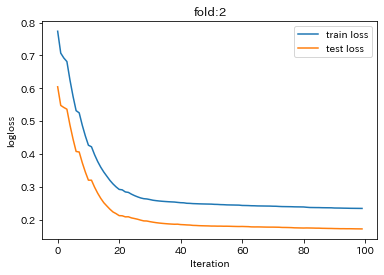

[I 2021-12-27 16:32:51,076] A new study created in memory with name: no-name-f459b266-7978-4c46-858e-c84da6ebd131


[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:52,265] Trial 0 finished with value: 0.09305587411644023 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.09305587411644023.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136853	Test's rmse: 0.0930559
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:53,193] Trial 1 finished with value: 0.09014609510889711 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.09014609510889711.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126647	Test's rmse: 0.0901461
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:54,136] Trial 2 finished with value: 0.0830657271294555 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.0830657271294555.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133355	Test's rmse: 0.0830657
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:54,912] Trial 3 finished with value: 0.021772541083253553 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.021772541083253553.


Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:55,765] Trial 4 finished with value: 0.05415092072554367 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.021772541083253553.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144156	Test's rmse: 0.0541509
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:56,583] Trial 5 finished with value: 0.04017005974914526 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.021772541083253553.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150344	Test's rmse: 0.0401701
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:57,425] Trial 6 finished with value: 0.08032294115549551 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.021772541083253553.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129613	Test's rmse: 0.0803229
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:32:59,493] Trial 7 finished with value: 0.02188603484912841 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.02188603484912841.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164193	Test's rmse: 0.021886
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:33:03,986] Trial 8 finished with value: 0.02215956316907056 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.02188603484912841.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221596
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:07,528] Trial 9 finished with value: 0.022159846062686058 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.02188603484912841.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165304	Test's rmse: 0.0221598
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:10,452] Trial 10 finished with value: 0.022029552104510804 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.02188603484912841.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164775	Test's rmse: 0.0220296
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:11,401] Trial 11 finished with value: 0.022568339423283852 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.02188603484912841.


Early stopping, best iteration is:
[42]	Train's rmse: 0.167063	Test's rmse: 0.0225683
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:12,305] Trial 12 finished with value: 0.022568339423283852 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.02188603484912841.


Early stopping, best iteration is:
[42]	Train's rmse: 0.167063	Test's rmse: 0.0225683
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:12,768] Trial 13 finished with value: 0.020285321149682702 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164398	Test's rmse: 0.0202853
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:16,633] Trial 14 finished with value: 0.022151878274247416 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221519
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:19,469] Trial 15 finished with value: 0.0220571992810797 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165916	Test's rmse: 0.0220572
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:22,608] Trial 16 finished with value: 0.02216779626015582 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[43]	Train's rmse: 0.166137	Test's rmse: 0.0221678
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:22,884] Trial 17 finished with value: 0.02479507423804574 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.020285321149682702.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153094	Test's rmse: 0.0247951
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:24,484] Trial 18 finished with value: 0.0219376452531013 and parameters: {'num_leaves': 82}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164804	Test's rmse: 0.0219376
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:26,620] Trial 19 finished with value: 0.022667395962731644 and parameters: {'num_leaves': 109}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[49]	Train's rmse: 0.161368	Test's rmse: 0.0226674
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:28,193] Trial 20 finished with value: 0.02213459130946076 and parameters: {'num_leaves': 86}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[42]	Train's rmse: 0.167388	Test's rmse: 0.0221346
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:28,547] Trial 21 finished with value: 0.021353008637956285 and parameters: {'num_leaves': 10}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[42]	Train's rmse: 0.168897	Test's rmse: 0.021353
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:28,875] Trial 22 finished with value: 0.02119890476538996 and parameters: {'num_leaves': 11}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[44]	Train's rmse: 0.16384	Test's rmse: 0.0211989
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:30,041] Trial 23 finished with value: 0.02141677516490814 and parameters: {'num_leaves': 54}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[44]	Train's rmse: 0.165823	Test's rmse: 0.0214168
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:30,264] Trial 24 finished with value: 0.02763101158186235 and parameters: {'num_leaves': 4}. Best is trial 13 with value: 0.020285321149682702.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173566	Test's rmse: 0.027631
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:31,323] Trial 25 finished with value: 0.022287558440883322 and parameters: {'num_leaves': 55}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[42]	Train's rmse: 0.169267	Test's rmse: 0.0222876
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:31,962] Trial 26 finished with value: 0.021935765796860664 and parameters: {'num_leaves': 27}. Best is trial 13 with value: 0.020285321149682702.


Early stopping, best iteration is:
[43]	Train's rmse: 0.165192	Test's rmse: 0.0219358
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:32,472] Trial 27 finished with value: 0.03606145745945127 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.03606145745945127.


Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.178339	Test's rmse: 0.0360615
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:33,028] Trial 28 finished with value: 0.030620784866022425 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.030620784866022425.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169153	Test's rmse: 0.0306208
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:33,685] Trial 29 finished with value: 0.026602859727458735 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 29 with value: 0.026602859727458735.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.178755	Test's rmse: 0.0266029
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:34,247] Trial 30 finished with value: 0.03182051169011222 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 29 with value: 0.026602859727458735.


Early stopping, best iteration is:
[35]	Train's rmse: 0.208456	Test's rmse: 0.0318205
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:34,961] Trial 31 finished with value: 0.032847527457702606 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 29 with value: 0.026602859727458735.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167231	Test's rmse: 0.0328475
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:35,702] Trial 32 finished with value: 0.03372409635467683 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 29 with value: 0.026602859727458735.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.188521	Test's rmse: 0.0337241
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:36,350] Trial 33 finished with value: 0.027835228127632845 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 29 with value: 0.026602859727458735.


Early stopping, best iteration is:
[38]	Train's rmse: 0.180086	Test's rmse: 0.0278352
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:37,049] Trial 34 finished with value: 0.02562673984116938 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 34 with value: 0.02562673984116938.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.17865	Test's rmse: 0.0256267
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:37,671] Trial 35 finished with value: 0.030049995392216727 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 34 with value: 0.02562673984116938.


Early stopping, best iteration is:
[44]	Train's rmse: 0.194408	Test's rmse: 0.03005
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:38,398] Trial 36 finished with value: 0.02942503881885 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 34 with value: 0.02562673984116938.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17389	Test's rmse: 0.029425
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:39,058] Trial 37 finished with value: 0.04129407513746761 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.04129407513746761.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15028	Test's rmse: 0.0412941
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:39,468] Trial 38 finished with value: 0.020285321149682702 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 0.020285321149682702.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164398	Test's rmse: 0.0202853
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:39,834] Trial 39 finished with value: 0.040700086990671326 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 38 with value: 0.020285321149682702.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15258	Test's rmse: 0.0407001
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:40,254] Trial 40 finished with value: 0.025581741599866495 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.025581741599866495.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149375	Test's rmse: 0.0255817
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:41,068] Trial 41 finished with value: 0.019831101860476725 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[49]	Train's rmse: 0.16803	Test's rmse: 0.0198311
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:41,469] Trial 42 finished with value: 0.020285321129922925 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164398	Test's rmse: 0.0202853
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:41,890] Trial 43 finished with value: 0.022249044425101935 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[43]	Train's rmse: 0.166682	Test's rmse: 0.022249
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:42,241] Trial 44 finished with value: 0.020678068175480856 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[44]	Train's rmse: 0.167822	Test's rmse: 0.0206781
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:42,633] Trial 45 finished with value: 0.02655680854897342 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 41 with value: 0.019831101860476725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152523	Test's rmse: 0.0265568
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:42,965] Trial 46 finished with value: 0.021323513723116777 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[47]	Train's rmse: 0.161151	Test's rmse: 0.0213235
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:43,257] Trial 47 finished with value: 0.020285321107039588 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164398	Test's rmse: 0.0202853
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:43,640] Trial 48 finished with value: 0.020285199088286496 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164399	Test's rmse: 0.0202852
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:43,907] Trial 49 finished with value: 0.02028533069921705 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164398	Test's rmse: 0.0202853
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 16:33:44,174] Trial 50 finished with value: 0.031101599405707118 and parameters: {'lambda_l1': 5.402896923508629, 'lambda_l2': 0.00018194741639177489}. Best is trial 41 with value: 0.019831101860476725.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:33:44,551] Trial 51 finished with value: 0.020372057056134065 and parameters: {'lambda_l1': 0.004908301797490369, 'lambda_l2': 0.0009771589136000017}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[44]	Train's rmse: 0.166499	Test's rmse: 0.0203721
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:44,837] Trial 52 finished with value: 0.028933827255714147 and parameters: {'lambda_l1': 0.06708272946489857, 'lambda_l2': 0.0003108365361430203}. Best is trial 41 with value: 0.019831101860476725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149054	Test's rmse: 0.0289338
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:45,116] Trial 53 finished with value: 0.02028389216299511 and parameters: {'lambda_l1': 3.601966653030624e-06, 'lambda_l2': 0.006152049296214337}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[43]	Train's rmse: 0.164404	Test's rmse: 0.0202839
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:45,404] Trial 54 finished with value: 0.029447324328788438 and parameters: {'lambda_l1': 0.0008472745658933207, 'lambda_l2': 0.044223173270844754}. Best is trial 41 with value: 0.019831101860476725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145035	Test's rmse: 0.0294473
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:45,762] Trial 55 finished with value: 0.020185309299245658 and parameters: {'lambda_l1': 0.05503926305649259, 'lambda_l2': 0.011297359459467275}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[43]	Train's rmse: 0.169378	Test's rmse: 0.0201853
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:46,271] Trial 56 finished with value: 0.022356922830272144 and parameters: {'lambda_l1': 0.06469738195422284, 'lambda_l2': 2.2689003690072427e-05}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[45]	Train's rmse: 0.16451	Test's rmse: 0.0223569
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2021-12-27 16:33:46,786] Trial 57 finished with value: 0.02659284993399034 and parameters: {'lambda_l1': 8.232907602810837, 'lambda_l2': 0.118760751687072}. Best is trial 41 with value: 0.019831101860476725.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:33:47,501] Trial 58 finished with value: 0.027167281954202482 and parameters: {'lambda_l1': 0.6112729537386181, 'lambda_l2': 0.0035747862607187334}. Best is trial 41 with value: 0.019831101860476725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137149	Test's rmse: 0.0271673
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:48,628] Trial 59 finished with value: 0.020372012610499094 and parameters: {'lambda_l1': 0.006269224708411151, 'lambda_l2': 3.0785615192833e-05}. Best is trial 41 with value: 0.019831101860476725.


Early stopping, best iteration is:
[44]	Train's rmse: 0.166499	Test's rmse: 0.020372
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:49,679] Trial 60 finished with value: 0.026766902156243503 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.026766902156243503.


Early stopping, best iteration is:
[39]	Train's rmse: 0.114847	Test's rmse: 0.0267669
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:50,922] Trial 61 finished with value: 0.05583387012256646 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.026766902156243503.


Early stopping, best iteration is:
[39]	Train's rmse: 0.25747	Test's rmse: 0.0558339
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:51,944] Trial 62 finished with value: 0.08968622604426885 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.026766902156243503.


Early stopping, best iteration is:
[29]	Train's rmse: 0.318707	Test's rmse: 0.0896862
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:52,662] Trial 63 finished with value: 0.024702041414482966 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.024702041414482966.


Early stopping, best iteration is:
[45]	Train's rmse: 0.051623	Test's rmse: 0.024702
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:53,428] Trial 64 finished with value: 0.02732685222581268 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.024702041414482966.


Early stopping, best iteration is:
[44]	Train's rmse: 0.175669	Test's rmse: 0.0273269


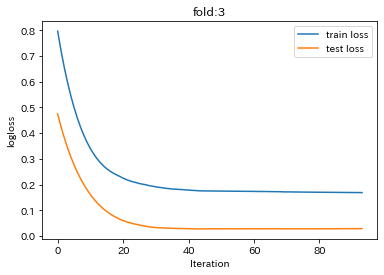

[I 2021-12-27 16:33:53,701] A new study created in memory with name: no-name-b88284c5-b632-461e-956e-197d5bd57a19


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:54,708] Trial 0 finished with value: 0.3912741168845798 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.3912741168845798.


Early stopping, best iteration is:
[42]	Train's rmse: 0.154665	Test's rmse: 0.391274
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:55,575] Trial 1 finished with value: 0.3730328037776354 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.3730328037776354.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:56,549] Trial 2 finished with value: 0.41867181945067966 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.3730328037776354.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121956	Test's rmse: 0.418672
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:57,588] Trial 3 finished with value: 0.41192885012396424 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.3730328037776354.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121667	Test's rmse: 0.411929
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:58,526] Trial 4 finished with value: 0.4177141650444445 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.3730328037776354.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122753	Test's rmse: 0.417714
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:33:59,399] Trial 5 finished with value: 0.3786815048787219 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.3730328037776354.


Early stopping, best iteration is:
[37]	Train's rmse: 0.15737	Test's rmse: 0.378682
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:00,409] Trial 6 finished with value: 0.4174154758767119 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.3730328037776354.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120118	Test's rmse: 0.417415
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:02,275] Trial 7 finished with value: 0.37606495936578416 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.37606495936578416.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159187	Test's rmse: 0.376065
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:34:06,562] Trial 8 finished with value: 0.3757680455073843 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.3757680455073843.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375768
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:09,907] Trial 9 finished with value: 0.37576783200939307 and parameters: {'num_leaves': 188}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:12,375] Trial 10 finished with value: 0.3760868230012915 and parameters: {'num_leaves': 154}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159181	Test's rmse: 0.376087
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:13,318] Trial 11 finished with value: 0.37614593179128786 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[31]	Train's rmse: 0.159713	Test's rmse: 0.376146
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:14,331] Trial 12 finished with value: 0.37614593179128786 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[31]	Train's rmse: 0.159713	Test's rmse: 0.376146
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:14,951] Trial 13 finished with value: 0.3758194796717933 and parameters: {'num_leaves': 16}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159073	Test's rmse: 0.375819
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:19,831] Trial 14 finished with value: 0.37606419630264315 and parameters: {'num_leaves': 222}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376064
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:23,911] Trial 15 finished with value: 0.37578044138282113 and parameters: {'num_leaves': 155}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.37578
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:29,272] Trial 16 finished with value: 0.3757805317973915 and parameters: {'num_leaves': 182}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375781
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:31,240] Trial 17 finished with value: 0.37607158599199136 and parameters: {'num_leaves': 83}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159194	Test's rmse: 0.376072
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:34:35,724] Trial 18 finished with value: 0.37576807859015954 and parameters: {'num_leaves': 246}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375768
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:39,113] Trial 19 finished with value: 0.3757680089310986 and parameters: {'num_leaves': 210}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:42,195] Trial 20 finished with value: 0.3757680157110867 and parameters: {'num_leaves': 198}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:45,218] Trial 21 finished with value: 0.37576792311197843 and parameters: {'num_leaves': 195}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:47,600] Trial 22 finished with value: 0.37608662867525156 and parameters: {'num_leaves': 164}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376087
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:49,244] Trial 23 finished with value: 0.37576883712487524 and parameters: {'num_leaves': 118}. Best is trial 9 with value: 0.37576783200939307.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153049	Test's rmse: 0.375769
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:50,656] Trial 24 finished with value: 0.3757660303044148 and parameters: {'num_leaves': 133}. Best is trial 24 with value: 0.3757660303044148.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153043	Test's rmse: 0.375766
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:51,875] Trial 25 finished with value: 0.3760694402302201 and parameters: {'num_leaves': 128}. Best is trial 24 with value: 0.3757660303044148.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159187	Test's rmse: 0.376069
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:52,823] Trial 26 finished with value: 0.37607158599199136 and parameters: {'num_leaves': 83}. Best is trial 24 with value: 0.3757660303044148.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159194	Test's rmse: 0.376072
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:53,317] Trial 27 finished with value: 0.35261228228639524 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.35261228228639524.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.159129	Test's rmse: 0.352612
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:53,839] Trial 28 finished with value: 0.3543661697225558 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 27 with value: 0.35261228228639524.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152564	Test's rmse: 0.354366
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:54,769] Trial 29 finished with value: 0.34931241992713213 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 29 with value: 0.34931241992713213.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165209	Test's rmse: 0.349312
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:55,941] Trial 30 finished with value: 0.35216654690472143 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 29 with value: 0.34931241992713213.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166646	Test's rmse: 0.352167
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:57,260] Trial 31 finished with value: 0.3570050847664473 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 29 with value: 0.34931241992713213.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155615	Test's rmse: 0.357005
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:58,154] Trial 32 finished with value: 0.35676060513320484 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 29 with value: 0.34931241992713213.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165696	Test's rmse: 0.356761
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:58,925] Trial 33 finished with value: 0.3427365619050977 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.3427365619050977.


Early stopping, best iteration is:
[42]	Train's rmse: 0.172864	Test's rmse: 0.342737
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:34:59,756] Trial 34 finished with value: 0.3509301904795023 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.3427365619050977.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165206	Test's rmse: 0.35093
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:00,792] Trial 35 finished with value: 0.3361038783257241 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 35 with value: 0.3361038783257241.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161307	Test's rmse: 0.336104
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:01,610] Trial 36 finished with value: 0.3467968007771705 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 35 with value: 0.3361038783257241.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161095	Test's rmse: 0.346797
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:02,416] Trial 37 finished with value: 0.3361038783257241 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.3361038783257241.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161307	Test's rmse: 0.336104
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:03,223] Trial 38 finished with value: 0.3515410319897715 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.3361038783257241.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.159427	Test's rmse: 0.351541
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:03,996] Trial 39 finished with value: 0.35011150031528215 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.3361038783257241.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.16193	Test's rmse: 0.350112
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2021-12-27 16:35:04,816] Trial 40 finished with value: 0.3404064433989817 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.3404064433989817.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165301	Test's rmse: 0.340406
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:35:05,510] Trial 41 finished with value: 0.3446739250367252 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 40 with value: 0.3404064433989817.


Early stopping, best iteration is:
[32]	Train's rmse: 0.188789	Test's rmse: 0.344674
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:06,481] Trial 42 finished with value: 0.33610316538018786 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 42 with value: 0.33610316538018786.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161307	Test's rmse: 0.336103
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:07,336] Trial 43 finished with value: 0.3394848122173843 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 42 with value: 0.33610316538018786.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.161094	Test's rmse: 0.339485
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:08,045] Trial 44 finished with value: 0.3436160060070788 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 42 with value: 0.33610316538018786.


Early stopping, best iteration is:
[32]	Train's rmse: 0.188615	Test's rmse: 0.343616
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2021-12-27 16:35:08,942] Trial 45 finished with value: 0.340220461357208 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 42 with value: 0.33610316538018786.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168402	Test's rmse: 0.34022
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2021-12-27 16:35:09,577] Trial 46 finished with value: 0.3443607088637601 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 42 with value: 0.33610316538018786.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[32]	Train's rmse: 0.189206	Test's rmse: 0.344361
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:10,572] Trial 47 finished with value: 0.3361031620909 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 47 with value: 0.3361031620909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161307	Test's rmse: 0.336103
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:11,380] Trial 48 finished with value: 0.33610309133488026 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 48 with value: 0.33610309133488026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161307	Test's rmse: 0.336103
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:12,258] Trial 49 finished with value: 0.33609011530282606 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 49 with value: 0.33609011530282606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161299	Test's rmse: 0.33609
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:13,177] Trial 50 finished with value: 0.33558750043600677 and parameters: {'lambda_l1': 0.0004944915061688625, 'lambda_l2': 1.755150973656557e-05}. Best is trial 50 with value: 0.33558750043600677.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161034	Test's rmse: 0.335588
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:13,996] Trial 51 finished with value: 0.3356208072949995 and parameters: {'lambda_l1': 0.000459551809456671, 'lambda_l2': 1.3232991168593193e-05}. Best is trial 50 with value: 0.33558750043600677.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161039	Test's rmse: 0.335621
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:14,908] Trial 52 finished with value: 0.33698280834260563 and parameters: {'lambda_l1': 0.002419886693121357, 'lambda_l2': 2.2401828100581764e-05}. Best is trial 50 with value: 0.33558750043600677.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.161811	Test's rmse: 0.336983
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:15,754] Trial 53 finished with value: 0.33525204880354637 and parameters: {'lambda_l1': 0.000857814817235375, 'lambda_l2': 1.7672147280754267e-08}. Best is trial 53 with value: 0.33525204880354637.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161131	Test's rmse: 0.335252
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:35:16,271] Trial 54 finished with value: 0.3324701413447544 and parameters: {'lambda_l1': 3.3316309468938208, 'lambda_l2': 1.1102733413747573e-08}. Best is trial 54 with value: 0.3324701413447544.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:35:16,638] Trial 55 finished with value: 0.33783718023881026 and parameters: {'lambda_l1': 8.654233931043295, 'lambda_l2': 1.1971379451947801e-08}. Best is trial 54 with value: 0.3324701413447544.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:35:17,139] Trial 56 finished with value: 0.33608184653398876 and parameters: {'lambda_l1': 4.0855210750382644, 'lambda_l2': 1.7755171529048455e-08}. Best is trial 54 with value: 0.3324701413447544.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168585	Test's rmse: 0.336082
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:35:18,095] Trial 57 finished with value: 0.34480571155331086 and parameters: {'lambda_l1': 0.07842341838123643, 'lambda_l2': 5.606079161046458e-08}. Best is trial 54 with value: 0.3324701413447544.


Early stopping, best iteration is:
[32]	Train's rmse: 0.188435	Test's rmse: 0.344806
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2021-12-27 16:35:18,885] Trial 58 finished with value: 0.3405443822151591 and parameters: {'lambda_l1': 0.6112729537386181, 'lambda_l2': 1.278714784455671e-07}. Best is trial 54 with value: 0.3324701413447544.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:35:19,782] Trial 59 finished with value: 0.34463118582661284 and parameters: {'lambda_l1': 0.022101268041355572, 'lambda_l2': 2.125155465347188e-06}. Best is trial 54 with value: 0.3324701413447544.


Early stopping, best iteration is:
[32]	Train's rmse: 0.188801	Test's rmse: 0.344631
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2021-12-27 16:35:20,404] Trial 60 finished with value: 0.38336195910568194 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.38336195910568194.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0800467	Test's rmse: 0.383362
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start

[I 2021-12-27 16:35:20,896] Trial 61 finished with value: 0.33377083018400266 and parameters: {'min_child_samples': 25}. Best is trial 61 with value: 0.33377083018400266.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:35:21,417] Trial 62 finished with value: 0.3425356464428821 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 0.33377083018400266.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[34]	Train's rmse: 0.152046	Test's rmse: 0.342536
[LightGBM] [Inf

[I 2021-12-27 16:35:21,953] Trial 63 finished with value: 0.511316798504825 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.33377083018400266.


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2021-12-27 16:35:22,418] Trial 64 finished with value: 0.4348912150891377 and parameters: {'min_child_samples': 50}. Best is trial 61 with value: 0.33377083018400266.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.213693	Test's rmse: 0.434891


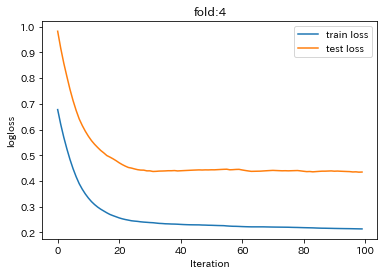

RMSE: [0.3187494000019128, 0.09648545105688833, 0.13686336202781252, 0.01983110070837394, 0.3324701417402649]
RMSE: 0.1808798911070505
elapsed_time:401.0[sec]


In [7]:
# 経過時間の測定
start = time.time()

y_train = y_train.reset_index(drop=True)

# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'deterministic':True,         # 再現性確保用のパラメータ
          'force_row_wise':True,        # 再現性確保用のパラメータ
          'seed': SEED                  # シード値
          }

best_params, history = {}, []

cv_result = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.LightGBMTuner(
                    params,                           # ハイパーパラメータをセット
                    train_set = lgb_train,            # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    show_progress_bar = False,        # プログレスバーの非表示
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    optuna_seed=SEED,
                    )

    # 訓練の実施
    model.run()
    
    best_params = model.best_params
    best_model = model.get_best_booster()

   # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = best_model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result.append(rmse)

print("RMSE:", cv_result)
print("RMSE:", np.mean(cv_result))

# 経過時間の測定
elasped_time = round((time.time() - start), 1)

print(f"elapsed_time:{elasped_time}[sec]")

## 量子化

In [8]:
X_train_ce = X_train_ce.astype(np.float16)

y_train = y_train.astype(np.float16)

In [9]:
# 目的変数
print(y_train.dtypes)

# 説明変数
display(pd.DataFrame(X_train_ce.dtypes).T)

float16


,Rank,Name,basename,Genre,ESRB_Rating_E,ESRB_Rating_T,ESRB_Rating_M,ESRB_Rating_E10,ESRB_Rating_EC,ESRB_Rating_RP,...,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Year,Last_Update,url,status,Vgchartzscore,img_url
0,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,...,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16


[I 2021-12-27 16:35:22,813] A new study created in memory with name: no-name-72e53d58-8ce2-4c1d-9720-299990d66dbd


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:23,876] Trial 0 finished with value: 0.35493817070597755 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.35493817070597755.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108948	Test's rmse: 0.354938
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:24,859] Trial 1 finished with value: 0.36099379236029133 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.35493817070597755.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119093	Test's rmse: 0.360994
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:25,934] Trial 2 finished with value: 0.3564885021940807 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.35493817070597755.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.106356	Test's rmse: 0.356489
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:26,861] Trial 3 finished with value: 0.3439911604827945 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.3439911604827945.


Early stopping, best iteration is:
[33]	Train's rmse: 0.159102	Test's rmse: 0.343991
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:27,870] Trial 4 finished with value: 0.3597478282747058 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.3439911604827945.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114165	Test's rmse: 0.359748
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:28,666] Trial 5 finished with value: 0.3411027535721024 and parameters: {'feature_fraction': 1.0}. Best is trial 5 with value: 0.3411027535721024.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125304	Test's rmse: 0.341103
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:29,530] Trial 6 finished with value: 0.33998427115563173 and parameters: {'feature_fraction': 0.8}. Best is trial 6 with value: 0.33998427115563173.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111228	Test's rmse: 0.339984
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:31,446] Trial 7 finished with value: 0.34057235747141057 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.34057235747141057.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114169	Test's rmse: 0.340572
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:35:35,521] Trial 8 finished with value: 0.3400121393528228 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.3400121393528228.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11393	Test's rmse: 0.340012
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:38,735] Trial 9 finished with value: 0.35029722813082287 and parameters: {'num_leaves': 188}. Best is trial 8 with value: 0.3400121393528228.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110759	Test's rmse: 0.350297
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:41,661] Trial 10 finished with value: 0.34463790782423026 and parameters: {'num_leaves': 154}. Best is trial 8 with value: 0.3400121393528228.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112708	Test's rmse: 0.344638
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:42,739] Trial 11 finished with value: 0.34380699065047593 and parameters: {'num_leaves': 41}. Best is trial 8 with value: 0.3400121393528228.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112759	Test's rmse: 0.343807
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:43,719] Trial 12 finished with value: 0.34380699065047593 and parameters: {'num_leaves': 41}. Best is trial 8 with value: 0.3400121393528228.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112759	Test's rmse: 0.343807
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:44,109] Trial 13 finished with value: 0.33862539524681773 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114712	Test's rmse: 0.338625
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:46,885] Trial 14 finished with value: 0.3452353793903017 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.113386	Test's rmse: 0.345235
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:49,796] Trial 15 finished with value: 0.3485746432009859 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11235	Test's rmse: 0.348575
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:53,433] Trial 16 finished with value: 0.34315621386501016 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.113854	Test's rmse: 0.343156
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:53,711] Trial 17 finished with value: 0.34147927576233456 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120456	Test's rmse: 0.341479
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:35:58,348] Trial 18 finished with value: 0.3471696707701191 and parameters: {'num_leaves': 239}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109955	Test's rmse: 0.34717
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:35:59,642] Trial 19 finished with value: 0.34934925002914646 and parameters: {'num_leaves': 83}. Best is trial 13 with value: 0.33862539524681773.


Early stopping, best iteration is:
[48]	Train's rmse: 0.138789	Test's rmse: 0.349349
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:01,158] Trial 20 finished with value: 0.34618513277493984 and parameters: {'num_leaves': 112}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.117556	Test's rmse: 0.346185
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:36:04,493] Trial 21 finished with value: 0.34217903439824043 and parameters: {'num_leaves': 252}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114573	Test's rmse: 0.342179
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:05,926] Trial 22 finished with value: 0.345514881163009 and parameters: {'num_leaves': 59}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114595	Test's rmse: 0.345515
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:06,163] Trial 23 finished with value: 0.34052585040343913 and parameters: {'num_leaves': 5}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141303	Test's rmse: 0.340526
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:09,991] Trial 24 finished with value: 0.3456799121496001 and parameters: {'num_leaves': 204}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112453	Test's rmse: 0.34568
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:12,618] Trial 25 finished with value: 0.344761270792361 and parameters: {'num_leaves': 141}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.113865	Test's rmse: 0.344761
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:14,298] Trial 26 finished with value: 0.3447740662289935 and parameters: {'num_leaves': 82}. Best is trial 13 with value: 0.33862539524681773.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108818	Test's rmse: 0.344774
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:14,817] Trial 27 finished with value: 0.32689659313956576 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.32689659313956576.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153582	Test's rmse: 0.326897
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:15,361] Trial 28 finished with value: 0.33796790457525805 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 27 with value: 0.32689659313956576.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129595	Test's rmse: 0.337968
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:15,905] Trial 29 finished with value: 0.3296062407649116 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 27 with value: 0.32689659313956576.


Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.159426	Test's rmse: 0.329606
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:16,395] Trial 30 finished with value: 0.3219407573191416 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 30 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:16,936] Trial 31 finished with value: 0.32945578862359887 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 30 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141023	Test's rmse: 0.329456
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:17,575] Trial 32 finished with value: 0.32590862215386485 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 30 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167073	Test's rmse: 0.325909
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:18,148] Trial 33 finished with value: 0.33528122422434326 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 30 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127627	Test's rmse: 0.335281
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:18,703] Trial 34 finished with value: 0.3276784568774288 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 30 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.156935	Test's rmse: 0.327678
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:19,246] Trial 35 finished with value: 0.331957425113419 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 30 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157794	Test's rmse: 0.331957
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:19,920] Trial 36 finished with value: 0.32308792713713613 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 30 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155774	Test's rmse: 0.323088
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:20,487] Trial 37 finished with value: 0.3237831380706959 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.3237831380706959.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168331	Test's rmse: 0.323783
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:21,041] Trial 38 finished with value: 0.3219407573191416 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:21,754] Trial 39 finished with value: 0.32752861480852147 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 38 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16638	Test's rmse: 0.327529
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:22,449] Trial 40 finished with value: 0.32752861480852147 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16638	Test's rmse: 0.327529
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:23,114] Trial 41 finished with value: 0.3317857020755431 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 38 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166214	Test's rmse: 0.331786
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:23,942] Trial 42 finished with value: 0.3237831380706959 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 38 with value: 0.3219407573191416.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168331	Test's rmse: 0.323783
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:24,867] Trial 43 finished with value: 0.3252449901043726 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.3252449901043726.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170399	Test's rmse: 0.325245
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:25,721] Trial 44 finished with value: 0.32308270136322786 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.32308270136322786.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168297	Test's rmse: 0.323083
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:26,744] Trial 45 finished with value: 0.3219407577769149 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.3219407577769149.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:27,664] Trial 46 finished with value: 0.32608254266664016 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 45 with value: 0.3219407577769149.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16752	Test's rmse: 0.326083
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:28,613] Trial 47 finished with value: 0.32292819156231967 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 45 with value: 0.3219407577769149.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168575	Test's rmse: 0.322928
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:29,464] Trial 48 finished with value: 0.32696342282523755 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.3219407577769149.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172388	Test's rmse: 0.326963
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:30,348] Trial 49 finished with value: 0.3239196586407491 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.3219407577769149.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168278	Test's rmse: 0.32392
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:31,093] Trial 50 finished with value: 0.320510852394026 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168223	Test's rmse: 0.320511
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:31,781] Trial 51 finished with value: 0.3219409594022396 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168912	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:32,496] Trial 52 finished with value: 0.3219408434545806 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:33,200] Trial 53 finished with value: 0.3219407581468014 and parameters: {'lambda_l1': 7.388726219576161e-07, 'lambda_l2': 1.1323342574941946e-08}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:33,895] Trial 54 finished with value: 0.3219407585356168 and parameters: {'lambda_l1': 4.1744842423393374e-07, 'lambda_l2': 1.99371629285331e-06}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:34,581] Trial 55 finished with value: 0.32342591221953976 and parameters: {'lambda_l1': 0.0012317365144257704, 'lambda_l2': 2.2311398834761413e-08}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167802	Test's rmse: 0.323426
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:35,294] Trial 56 finished with value: 0.3219407707005578 and parameters: {'lambda_l1': 7.983530213341236e-07, 'lambda_l2': 3.404677878190547e-05}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:36,002] Trial 57 finished with value: 0.3219407575494914 and parameters: {'lambda_l1': 1.299413633838622e-07, 'lambda_l2': 1.3488906627463703e-07}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:36:36,692] Trial 58 finished with value: 0.340912098313651 and parameters: {'lambda_l1': 5.103027507670196, 'lambda_l2': 4.624083095518924e-05}. Best is trial 50 with value: 0.320510852394026.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166345	Test's rmse: 0.340912
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:37,425] Trial 59 finished with value: 0.3219407614415299 and parameters: {'lambda_l1': 3.753757748769746e-06, 'lambda_l2': 1.0822029432991615e-07}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:38,161] Trial 60 finished with value: 0.3219407634627561 and parameters: {'lambda_l1': 5.047021740592602e-08, 'lambda_l2': 1.6282662061664502e-05}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:38,935] Trial 61 finished with value: 0.3219408470010787 and parameters: {'lambda_l1': 8.19565271554398e-05, 'lambda_l2': 9.76575225313624e-08}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168911	Test's rmse: 0.321941
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:39,680] Trial 62 finished with value: 0.3228476896600011 and parameters: {'lambda_l1': 6.06766721396595e-06, 'lambda_l2': 0.008739030123082584}. Best is trial 50 with value: 0.320510852394026.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168425	Test's rmse: 0.322848
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:40,365] Trial 63 finished with value: 0.47306177663279064 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.47306177663279064.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.316826	Test's rmse: 0.473062
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:40,911] Trial 64 finished with value: 0.371589143950496 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.371589143950496.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.207602	Test's rmse: 0.371589
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:41,486] Trial 65 finished with value: 0.39987886494267905 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.371589143950496.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.258053	Test's rmse: 0.399879
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:42,021] Trial 66 finished with value: 0.33773221587384694 and parameters: {'min_child_samples': 10}. Best is trial 66 with value: 0.33773221587384694.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138933	Test's rmse: 0.337732
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356347
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:42,684] Trial 67 finished with value: 0.3471282282156179 and parameters: {'min_child_samples': 5}. Best is trial 66 with value: 0.33773221587384694.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0887947	Test's rmse: 0.347128


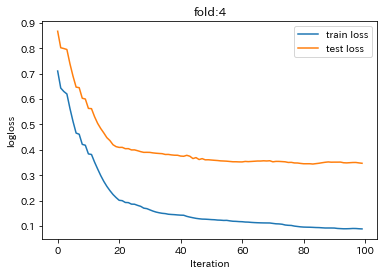

[I 2021-12-27 16:36:42,933] A new study created in memory with name: no-name-4456fcc7-941d-4e02-b0a6-089fd79368c2


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:43,786] Trial 0 finished with value: 0.12286108562825501 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.12286108562825501.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12925	Test's rmse: 0.122861
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:44,665] Trial 1 finished with value: 0.1265381086143078 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.12286108562825501.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132242	Test's rmse: 0.126538
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:45,481] Trial 2 finished with value: 0.11863716730101535 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.11863716730101535.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132101	Test's rmse: 0.118637
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:46,262] Trial 3 finished with value: 0.10511044639140016 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.10511044639140016.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158535	Test's rmse: 0.10511
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:47,123] Trial 4 finished with value: 0.13520774661276216 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.10511044639140016.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140673	Test's rmse: 0.135208
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:47,913] Trial 5 finished with value: 0.10502356670811903 and parameters: {'feature_fraction': 0.8}. Best is trial 5 with value: 0.10502356670811903.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140677	Test's rmse: 0.105024
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:48,929] Trial 6 finished with value: 0.10763431315465817 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 0.10502356670811903.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151773	Test's rmse: 0.107634
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:36:51,796] Trial 7 finished with value: 0.11226898793529963 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.11226898793529963.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14111	Test's rmse: 0.112269
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:36:56,700] Trial 8 finished with value: 0.12039540185130805 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.11226898793529963.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147483	Test's rmse: 0.120395
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:00,408] Trial 9 finished with value: 0.11805912893723189 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.11226898793529963.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145772	Test's rmse: 0.118059
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:03,288] Trial 10 finished with value: 0.11670482140709107 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.11226898793529963.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144262	Test's rmse: 0.116705
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:03,765] Trial 11 finished with value: 0.11073764987023976 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.11073764987023976.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139397	Test's rmse: 0.110738
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:04,653] Trial 12 finished with value: 0.11073764987023976 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.11073764987023976.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139397	Test's rmse: 0.110738
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:04,992] Trial 13 finished with value: 0.11133471943404484 and parameters: {'num_leaves': 16}. Best is trial 11 with value: 0.11073764987023976.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147621	Test's rmse: 0.111335
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:07,625] Trial 14 finished with value: 0.11945830914860331 and parameters: {'num_leaves': 222}. Best is trial 11 with value: 0.11073764987023976.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148095	Test's rmse: 0.119458
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:09,861] Trial 15 finished with value: 0.11435537993706198 and parameters: {'num_leaves': 155}. Best is trial 11 with value: 0.11073764987023976.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141523	Test's rmse: 0.114355
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:16,327] Trial 16 finished with value: 0.118273086404182 and parameters: {'num_leaves': 182}. Best is trial 11 with value: 0.11073764987023976.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146373	Test's rmse: 0.118273
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:18,790] Trial 17 finished with value: 0.11236094169600387 and parameters: {'num_leaves': 81}. Best is trial 11 with value: 0.11073764987023976.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140498	Test's rmse: 0.112361
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:18,998] Trial 18 finished with value: 0.12234769058038046 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.11073764987023976.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.2182	Test's rmse: 0.122348
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:20,724] Trial 19 finished with value: 0.11014537395953042 and parameters: {'num_leaves': 56}. Best is trial 19 with value: 0.11014537395953042.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144994	Test's rmse: 0.110145
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:22,194] Trial 20 finished with value: 0.1102001880099231 and parameters: {'num_leaves': 65}. Best is trial 19 with value: 0.11014537395953042.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141274	Test's rmse: 0.1102
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:24,095] Trial 21 finished with value: 0.11327921322408424 and parameters: {'num_leaves': 90}. Best is trial 19 with value: 0.11014537395953042.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142532	Test's rmse: 0.113279
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:25,486] Trial 22 finished with value: 0.10967365181020493 and parameters: {'num_leaves': 61}. Best is trial 22 with value: 0.10967365181020493.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142836	Test's rmse: 0.109674
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:27,854] Trial 23 finished with value: 0.11568382138184215 and parameters: {'num_leaves': 115}. Best is trial 22 with value: 0.10967365181020493.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143702	Test's rmse: 0.115684
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:28,915] Trial 24 finished with value: 0.11428719637494966 and parameters: {'num_leaves': 47}. Best is trial 22 with value: 0.10967365181020493.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14512	Test's rmse: 0.114287
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:31,441] Trial 25 finished with value: 0.11795291856919639 and parameters: {'num_leaves': 125}. Best is trial 22 with value: 0.10967365181020493.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144039	Test's rmse: 0.117953
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:32,754] Trial 26 finished with value: 0.10967365181020493 and parameters: {'num_leaves': 61}. Best is trial 22 with value: 0.10967365181020493.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142836	Test's rmse: 0.109674
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:33,545] Trial 27 finished with value: 0.11744729860736078 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.11744729860736078.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.188624	Test's rmse: 0.117447
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:34,461] Trial 28 finished with value: 0.11617670521846056 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.11617670521846056.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.163057	Test's rmse: 0.116177
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:35,298] Trial 29 finished with value: 0.11066550195284083 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 29 with value: 0.11066550195284083.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.185051	Test's rmse: 0.110666
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:36,111] Trial 30 finished with value: 0.12818599145330165 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 29 with value: 0.11066550195284083.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.192912	Test's rmse: 0.128186
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:36,954] Trial 31 finished with value: 0.11356717091388532 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 29 with value: 0.11066550195284083.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16992	Test's rmse: 0.113567
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:37,745] Trial 32 finished with value: 0.1206167296160942 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 29 with value: 0.11066550195284083.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.192883	Test's rmse: 0.120617
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:38,555] Trial 33 finished with value: 0.1020616412524425 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.1020616412524425.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150927	Test's rmse: 0.102062
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:39,371] Trial 34 finished with value: 0.11424580397465467 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.1020616412524425.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.187077	Test's rmse: 0.114246
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:40,217] Trial 35 finished with value: 0.11712887697026322 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.1020616412524425.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.190206	Test's rmse: 0.117129
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:41,017] Trial 36 finished with value: 0.10655128782430519 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.1020616412524425.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175287	Test's rmse: 0.106551
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:41,858] Trial 37 finished with value: 0.11236222579677393 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.11236222579677393.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148928	Test's rmse: 0.112362
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:42,659] Trial 38 finished with value: 0.11236222579677393 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.11236222579677393.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148928	Test's rmse: 0.112362
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:43,491] Trial 39 finished with value: 0.10695533982831479 and parameters: {'feature_fraction': 0.88}. Best is trial 39 with value: 0.10695533982831479.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15516	Test's rmse: 0.106955
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:44,324] Trial 40 finished with value: 0.10695533982831479 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 39 with value: 0.10695533982831479.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15516	Test's rmse: 0.106955
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:45,135] Trial 41 finished with value: 0.11600413485032747 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 39 with value: 0.10695533982831479.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148975	Test's rmse: 0.116004
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:45,921] Trial 42 finished with value: 0.1020616412524425 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 42 with value: 0.1020616412524425.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150927	Test's rmse: 0.102062
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:46,773] Trial 43 finished with value: 0.10667507473572821 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.10667507473572821.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150796	Test's rmse: 0.106675
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:47,658] Trial 44 finished with value: 0.10669103911891491 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 43 with value: 0.10667507473572821.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151953	Test's rmse: 0.106691
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:48,603] Trial 45 finished with value: 0.10208624351227533 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.10208624351227533.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150882	Test's rmse: 0.102086
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:49,462] Trial 46 finished with value: 0.10328276826121495 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 45 with value: 0.10208624351227533.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147909	Test's rmse: 0.103283
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:50,443] Trial 47 finished with value: 0.10283998865603959 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 45 with value: 0.10208624351227533.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150542	Test's rmse: 0.10284
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:37:51,352] Trial 48 finished with value: 0.10622540919875614 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.10208624351227533.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154017	Test's rmse: 0.106225
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:52,370] Trial 49 finished with value: 0.10590247895528276 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.10208624351227533.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149824	Test's rmse: 0.105902
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:53,548] Trial 50 finished with value: 0.10208633475592668 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 45 with value: 0.10208624351227533.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150882	Test's rmse: 0.102086
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:54,698] Trial 51 finished with value: 0.1020862707315306 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 45 with value: 0.10208624351227533.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150883	Test's rmse: 0.102086
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:55,833] Trial 52 finished with value: 0.10159232730776284 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 52 with value: 0.10159232730776284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151131	Test's rmse: 0.101592
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:57,093] Trial 53 finished with value: 0.10257638599295041 and parameters: {'lambda_l1': 0.0004944915061688625, 'lambda_l2': 1.755150973656557e-05}. Best is trial 52 with value: 0.10159232730776284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150283	Test's rmse: 0.102576
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:58,391] Trial 54 finished with value: 0.10208624945627083 and parameters: {'lambda_l1': 6.855588146086897e-06, 'lambda_l2': 1.4295277924458138e-08}. Best is trial 52 with value: 0.10159232730776284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150882	Test's rmse: 0.102086
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:37:59,586] Trial 55 finished with value: 0.1024414124990798 and parameters: {'lambda_l1': 0.00010132525971181927, 'lambda_l2': 9.28036752000233e-06}. Best is trial 52 with value: 0.10159232730776284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151228	Test's rmse: 0.102441
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:00,757] Trial 56 finished with value: 0.10208624405240786 and parameters: {'lambda_l1': 9.051114851415055e-07, 'lambda_l2': 1.2315147429448886e-08}. Best is trial 52 with value: 0.10159232730776284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150882	Test's rmse: 0.102086
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:38:01,922] Trial 57 finished with value: 0.10951752958129496 and parameters: {'lambda_l1': 3.3316309468938208, 'lambda_l2': 1.190871867655124e-05}. Best is trial 52 with value: 0.10159232730776284.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148557	Test's rmse: 0.109518
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:03,126] Trial 58 finished with value: 0.10208624356848221 and parameters: {'lambda_l1': 3.4085055624960927e-07, 'lambda_l2': 5.119208864168971e-07}. Best is trial 52 with value: 0.10159232730776284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150882	Test's rmse: 0.102086
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:04,313] Trial 59 finished with value: 0.10527475015040397 and parameters: {'lambda_l1': 0.00353936841708647, 'lambda_l2': 1.2657722109905184e-07}. Best is trial 52 with value: 0.10159232730776284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149153	Test's rmse: 0.105275
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:05,494] Trial 60 finished with value: 0.10189867841460251 and parameters: {'lambda_l1': 0.00017964951948595568, 'lambda_l2': 3.801707768132749e-05}. Best is trial 52 with value: 0.10159232730776284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151135	Test's rmse: 0.101899
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:06,642] Trial 61 finished with value: 0.10189875234635803 and parameters: {'lambda_l1': 0.0002450266077215033, 'lambda_l2': 0.00011501530926588801}. Best is trial 52 with value: 0.10159232730776284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151135	Test's rmse: 0.101899
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:07,829] Trial 62 finished with value: 0.10624261763457937 and parameters: {'lambda_l1': 0.017289029128938076, 'lambda_l2': 0.014343518977276915}. Best is trial 52 with value: 0.10159232730776284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149813	Test's rmse: 0.106243
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:08,809] Trial 63 finished with value: 0.1839198303984953 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.1839198303984953.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.243912	Test's rmse: 0.18392
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:09,353] Trial 64 finished with value: 0.23323973247130697 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.1839198303984953.


Early stopping, best iteration is:
[25]	Train's rmse: 0.343479	Test's rmse: 0.23324
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:10,416] Trial 65 finished with value: 0.10729353251554898 and parameters: {'min_child_samples': 25}. Best is trial 65 with value: 0.10729353251554898.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164542	Test's rmse: 0.107294
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:11,220] Trial 66 finished with value: 0.11547014607423187 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.10729353251554898.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0752642	Test's rmse: 0.11547
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:11,798] Trial 67 finished with value: 0.11615505677905875 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.10729353251554898.


Early stopping, best iteration is:
[46]	Train's rmse: 0.0758293	Test's rmse: 0.116155


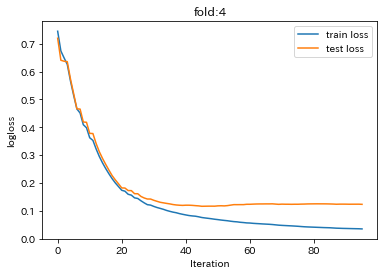

[I 2021-12-27 16:38:12,048] A new study created in memory with name: no-name-2136dc51-105c-415d-991e-efcb787918bb


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:12,620] Trial 0 finished with value: 0.14062647462852707 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.14062647462852707.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156569	Test's rmse: 0.140626
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:13,260] Trial 1 finished with value: 0.14159464829708104 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.14062647462852707.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150049	Test's rmse: 0.141595
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:13,783] Trial 2 finished with value: 0.169378194284046 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.14062647462852707.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136228	Test's rmse: 0.169378
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:14,234] Trial 3 finished with value: 0.15219473992669333 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.14062647462852707.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128399	Test's rmse: 0.152195
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:14,669] Trial 4 finished with value: 0.14084872127208578 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.14062647462852707.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144912	Test's rmse: 0.140849
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:15,529] Trial 5 finished with value: 0.16063327646339334 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.14062647462852707.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12754	Test's rmse: 0.160633
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:16,496] Trial 6 finished with value: 0.15989513995738283 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.14062647462852707.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127866	Test's rmse: 0.159895
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:19,289] Trial 7 finished with value: 0.14144414600789712 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.14144414600789712.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160135	Test's rmse: 0.141444
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:38:23,841] Trial 8 finished with value: 0.14008744012582514 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142393	Test's rmse: 0.140087
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:27,342] Trial 9 finished with value: 0.1437749802363093 and parameters: {'num_leaves': 188}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152074	Test's rmse: 0.143775
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:30,995] Trial 10 finished with value: 0.14138924447618267 and parameters: {'num_leaves': 154}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145076	Test's rmse: 0.141389
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:32,266] Trial 11 finished with value: 0.14029743419602803 and parameters: {'num_leaves': 41}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15035	Test's rmse: 0.140297
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:33,300] Trial 12 finished with value: 0.14029743419602803 and parameters: {'num_leaves': 41}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15035	Test's rmse: 0.140297
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:33,865] Trial 13 finished with value: 0.14138349943377582 and parameters: {'num_leaves': 16}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144269	Test's rmse: 0.141383
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:37,911] Trial 14 finished with value: 0.1410205108359184 and parameters: {'num_leaves': 222}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144353	Test's rmse: 0.141021
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:40,856] Trial 15 finished with value: 0.14104308451571446 and parameters: {'num_leaves': 155}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145357	Test's rmse: 0.141043
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:44,892] Trial 16 finished with value: 0.14014022682238747 and parameters: {'num_leaves': 182}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14644	Test's rmse: 0.14014
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:38:50,885] Trial 17 finished with value: 0.143235356449725 and parameters: {'num_leaves': 251}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147673	Test's rmse: 0.143235
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:38:54,843] Trial 18 finished with value: 0.14176620547629304 and parameters: {'num_leaves': 208}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1453	Test's rmse: 0.141766
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:38:59,184] Trial 19 finished with value: 0.143235356449725 and parameters: {'num_leaves': 251}. Best is trial 8 with value: 0.14008744012582514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147673	Test's rmse: 0.143235
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:01,496] Trial 20 finished with value: 0.1386603512104799 and parameters: {'num_leaves': 118}. Best is trial 20 with value: 0.1386603512104799.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145318	Test's rmse: 0.13866
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:03,542] Trial 21 finished with value: 0.13902475856081103 and parameters: {'num_leaves': 103}. Best is trial 20 with value: 0.1386603512104799.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144467	Test's rmse: 0.139025
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:05,475] Trial 22 finished with value: 0.14178407357617456 and parameters: {'num_leaves': 98}. Best is trial 20 with value: 0.1386603512104799.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160302	Test's rmse: 0.141784
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:07,755] Trial 23 finished with value: 0.14082274680541707 and parameters: {'num_leaves': 107}. Best is trial 20 with value: 0.1386603512104799.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148569	Test's rmse: 0.140823
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:09,246] Trial 24 finished with value: 0.13817473163790842 and parameters: {'num_leaves': 73}. Best is trial 24 with value: 0.13817473163790842.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148393	Test's rmse: 0.138175
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:10,846] Trial 25 finished with value: 0.13822129967512922 and parameters: {'num_leaves': 75}. Best is trial 24 with value: 0.13817473163790842.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14909	Test's rmse: 0.138221
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:11,657] Trial 26 finished with value: 0.13820962360048655 and parameters: {'num_leaves': 61}. Best is trial 24 with value: 0.13817473163790842.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146215	Test's rmse: 0.13821
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:13,132] Trial 27 finished with value: 0.15877862586408464 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.15877862586408464.


Early stopping, best iteration is:
[49]	Train's rmse: 0.202741	Test's rmse: 0.158779
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:14,486] Trial 28 finished with value: 0.1414901564630714 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.1414901564630714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159188	Test's rmse: 0.14149
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:15,865] Trial 29 finished with value: 0.14893897243379056 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.1414901564630714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.184924	Test's rmse: 0.148939
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:17,208] Trial 30 finished with value: 0.1560443124598149 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.1414901564630714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182663	Test's rmse: 0.156044
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:18,832] Trial 31 finished with value: 0.14930928833056667 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.1414901564630714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.163615	Test's rmse: 0.149309
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:21,988] Trial 32 finished with value: 0.1649979375016623 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.1414901564630714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181485	Test's rmse: 0.164998
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:24,714] Trial 33 finished with value: 0.14167611259289034 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 28 with value: 0.1414901564630714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149295	Test's rmse: 0.141676
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:26,994] Trial 34 finished with value: 0.15505548045226292 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 28 with value: 0.1414901564630714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182864	Test's rmse: 0.155055
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:29,131] Trial 35 finished with value: 0.1483870973714301 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 28 with value: 0.1414901564630714.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174912	Test's rmse: 0.148387
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:31,296] Trial 36 finished with value: 0.15105560237794605 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 28 with value: 0.1414901564630714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176575	Test's rmse: 0.151056
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:33,043] Trial 37 finished with value: 0.137997273634092 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 0.137997273634092.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143549	Test's rmse: 0.137997
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:34,654] Trial 38 finished with value: 0.14265663221891012 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 0.137997273634092.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148017	Test's rmse: 0.142657
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:36,270] Trial 39 finished with value: 0.137997273634092 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 0.137997273634092.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143549	Test's rmse: 0.137997
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:37,825] Trial 40 finished with value: 0.13817473163790842 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 0.137997273634092.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148393	Test's rmse: 0.138175
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:39,401] Trial 41 finished with value: 0.14209808194851434 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.137997273634092.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141809	Test's rmse: 0.142098
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:40,905] Trial 42 finished with value: 0.14260867124188895 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.137997273634092.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148174	Test's rmse: 0.142609
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:39:42,562] Trial 43 finished with value: 0.14687861815308878 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.14687861815308878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145247	Test's rmse: 0.146879
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:39:44,179] Trial 44 finished with value: 0.13662349514576386 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142486	Test's rmse: 0.136623
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:45,854] Trial 45 finished with value: 0.13795874984430992 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143532	Test's rmse: 0.137959
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:39:47,499] Trial 46 finished with value: 0.1400731760098053 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143201	Test's rmse: 0.140073
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:49,119] Trial 47 finished with value: 0.1367370251130767 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143251	Test's rmse: 0.136737
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:39:50,700] Trial 48 finished with value: 0.15120127857410134 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14284	Test's rmse: 0.151201
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2021-12-27 16:39:52,251] Trial 49 finished with value: 0.14233829906917242 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148076	Test's rmse: 0.142338
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:53,890] Trial 50 finished with value: 0.13795875031752325 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143532	Test's rmse: 0.137959
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:55,479] Trial 51 finished with value: 0.13939036901458662 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145439	Test's rmse: 0.13939
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:39:57,119] Trial 52 finished with value: 0.13672815990666398 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145767	Test's rmse: 0.136728
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:39:58,029] Trial 53 finished with value: 0.15237303774365268 and parameters: {'lambda_l1': 5.402896923508629, 'lambda_l2': 0.00018194741639177489}. Best is trial 44 with value: 0.13662349514576386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:39:59,804] Trial 54 finished with value: 0.14130417159149514 and parameters: {'lambda_l1': 0.002230652810043609, 'lambda_l2': 4.523205943145397e-05}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145422	Test's rmse: 0.141304
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:40:01,396] Trial 55 finished with value: 0.13938248791552507 and parameters: {'lambda_l1': 0.040117751008693976, 'lambda_l2': 0.01151714907819819}. Best is trial 44 with value: 0.13662349514576386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143477	Test's rmse: 0.139382
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:03,067] Trial 56 finished with value: 0.13568795259606214 and parameters: {'lambda_l1': 0.00012975930636568425, 'lambda_l2': 8.476957030644476e-06}. Best is trial 56 with value: 0.13568795259606214.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144778	Test's rmse: 0.135688
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:04,683] Trial 57 finished with value: 0.13677828739492623 and parameters: {'lambda_l1': 0.0013334121109595057, 'lambda_l2': 1.3139855587432983e-08}. Best is trial 56 with value: 0.13568795259606214.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146536	Test's rmse: 0.136778
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:40:06,256] Trial 58 finished with value: 0.13889399703705962 and parameters: {'lambda_l1': 0.05503926305649259, 'lambda_l2': 0.0036065358780523337}. Best is trial 56 with value: 0.13568795259606214.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145974	Test's rmse: 0.138894
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:40:07,726] Trial 59 finished with value: 0.1470791916349076 and parameters: {'lambda_l1': 1.2724755776699341, 'lambda_l2': 1.5252369760961e-05}. Best is trial 56 with value: 0.13568795259606214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143382	Test's rmse: 0.147079
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:40:09,518] Trial 60 finished with value: 0.13722627493435857 and parameters: {'lambda_l1': 0.022371892649144732, 'lambda_l2': 0.118760751687072}. Best is trial 56 with value: 0.13568795259606214.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145442	Test's rmse: 0.137226
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:11,629] Trial 61 finished with value: 0.13687855094008572 and parameters: {'lambda_l1': 0.00018512209836100103, 'lambda_l2': 0.001288634586755099}. Best is trial 56 with value: 0.13568795259606214.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145376	Test's rmse: 0.136879
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:13,947] Trial 62 finished with value: 0.13730823886696106 and parameters: {'lambda_l1': 5.021233082851738e-06, 'lambda_l2': 9.47435999353886e-05}. Best is trial 56 with value: 0.13568795259606214.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144771	Test's rmse: 0.137308
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:40:16,110] Trial 63 finished with value: 0.19493373063783362 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.19493373063783362.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.285986	Test's rmse: 0.194934
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:18,008] Trial 64 finished with value: 0.15516336603572928 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.15516336603572928.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0634953	Test's rmse: 0.155163
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:19,856] Trial 65 finished with value: 0.172230773679219 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.15516336603572928.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.233027	Test's rmse: 0.172231
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:21,025] Trial 66 finished with value: 0.164518959901992 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 0.15516336603572928.


Early stopping, best iteration is:
[44]	Train's rmse: 0.0574453	Test's rmse: 0.164519
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383110
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:22,284] Trial 67 finished with value: 0.152600428118031 and parameters: {'min_child_samples': 25}. Best is trial 67 with value: 0.152600428118031.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155917	Test's rmse: 0.1526


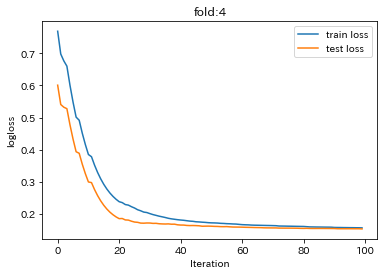

[I 2021-12-27 16:40:22,643] A new study created in memory with name: no-name-59caa3ac-bb82-4fcf-ae8c-0e626615c64d


[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:23,307] Trial 0 finished with value: 0.022023373500889103 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.022023373500889103.


Early stopping, best iteration is:
[42]	Train's rmse: 0.171115	Test's rmse: 0.0220234
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:23,845] Trial 1 finished with value: 0.04415446088946053 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.022023373500889103.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146974	Test's rmse: 0.0441545
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:24,393] Trial 2 finished with value: 0.05569880675786479 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.022023373500889103.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145359	Test's rmse: 0.0556988
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:25,229] Trial 3 finished with value: 0.08934243981976221 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.022023373500889103.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12864	Test's rmse: 0.0893424
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:26,357] Trial 4 finished with value: 0.09477626569818655 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.022023373500889103.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138178	Test's rmse: 0.0947763
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:28,506] Trial 5 finished with value: 0.08450552633120592 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.022023373500889103.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127382	Test's rmse: 0.0845055
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:30,642] Trial 6 finished with value: 0.09125317543283795 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.022023373500889103.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12539	Test's rmse: 0.0912532
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:32,943] Trial 7 finished with value: 0.021458228126645554 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.021458228126645554.


Early stopping, best iteration is:
[43]	Train's rmse: 0.171715	Test's rmse: 0.0214582
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:37,161] Trial 8 finished with value: 0.021515893354592655 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.021458228126645554.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171535	Test's rmse: 0.0215159
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:40,478] Trial 9 finished with value: 0.021600662770028985 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.021458228126645554.


Early stopping, best iteration is:
[47]	Train's rmse: 0.170526	Test's rmse: 0.0216007
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:43,249] Trial 10 finished with value: 0.021568773424831447 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.021458228126645554.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171425	Test's rmse: 0.0215688
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:44,180] Trial 11 finished with value: 0.02128582747480938 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.02128582747480938.


Early stopping, best iteration is:
[43]	Train's rmse: 0.170905	Test's rmse: 0.0212858
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:45,145] Trial 12 finished with value: 0.02128582747480938 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.02128582747480938.


Early stopping, best iteration is:
[43]	Train's rmse: 0.170905	Test's rmse: 0.0212858
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:45,662] Trial 13 finished with value: 0.019645882502504312 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:50,387] Trial 14 finished with value: 0.02160547763539008 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[47]	Train's rmse: 0.170525	Test's rmse: 0.0216055
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:53,469] Trial 15 finished with value: 0.021553955043310008 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171425	Test's rmse: 0.021554
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:56,744] Trial 16 finished with value: 0.021508341861408084 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171537	Test's rmse: 0.0215083
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:57,032] Trial 17 finished with value: 0.02076811233763841 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.019645882502504312.
[I 2021-12-27 16:40:57,206] Trial 18 finished with value: 0.046479335870014675 and parameters: {'num_leaves': 2}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[49]	Train's rmse: 0.174285	Test's rmse: 0.0207681
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.209583	Test's rmse: 0.0464793
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:40:58,885] Trial 19 finished with value: 0.02154278729339885 and parameters: {'num_leaves': 88}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[43]	Train's rmse: 0.171719	Test's rmse: 0.0215428
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196137	Test's rmse: 0.0408927


[I 2021-12-27 16:40:59,081] Trial 20 finished with value: 0.04089268823335628 and parameters: {'num_leaves': 3}. Best is trial 13 with value: 0.019645882502504312.


[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:00,247] Trial 21 finished with value: 0.021449155886468573 and parameters: {'num_leaves': 47}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[45]	Train's rmse: 0.169929	Test's rmse: 0.0214492
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:02,360] Trial 22 finished with value: 0.0216056446541723 and parameters: {'num_leaves': 83}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[42]	Train's rmse: 0.172302	Test's rmse: 0.0216056
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:03,997] Trial 23 finished with value: 0.021711967389211967 and parameters: {'num_leaves': 59}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[47]	Train's rmse: 0.170187	Test's rmse: 0.021712
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:04,658] Trial 24 finished with value: 0.02036067758834989 and parameters: {'num_leaves': 19}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[44]	Train's rmse: 0.167578	Test's rmse: 0.0203607
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:07,410] Trial 25 finished with value: 0.02164196616728898 and parameters: {'num_leaves': 114}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[43]	Train's rmse: 0.171964	Test's rmse: 0.021642
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:08,970] Trial 26 finished with value: 0.021722179301192197 and parameters: {'num_leaves': 61}. Best is trial 13 with value: 0.019645882502504312.


Early stopping, best iteration is:
[42]	Train's rmse: 0.172147	Test's rmse: 0.0217222
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:09,640] Trial 27 finished with value: 0.026878136887728395 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.026878136887728395.


Did not meet early stopping. Best iteration is:
[94]	Train's rmse: 0.184001	Test's rmse: 0.0268781
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:10,343] Trial 28 finished with value: 0.029085612876016333 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 27 with value: 0.026878136887728395.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167277	Test's rmse: 0.0290856
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:11,184] Trial 29 finished with value: 0.02575731501041505 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 29 with value: 0.02575731501041505.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.178105	Test's rmse: 0.0257573
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:11,868] Trial 30 finished with value: 0.03823719996628369 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 29 with value: 0.02575731501041505.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.194681	Test's rmse: 0.0382372
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:12,552] Trial 31 finished with value: 0.02792006778810098 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 29 with value: 0.02575731501041505.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169959	Test's rmse: 0.0279201
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:13,217] Trial 32 finished with value: 0.03227964841910664 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 29 with value: 0.02575731501041505.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.189996	Test's rmse: 0.0322796
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:13,944] Trial 33 finished with value: 0.020170208226478942 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.020170208226478942.


Early stopping, best iteration is:
[46]	Train's rmse: 0.176802	Test's rmse: 0.0201702
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:14,609] Trial 34 finished with value: 0.02806645731261072 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.020170208226478942.


Early stopping, best iteration is:
[36]	Train's rmse: 0.199964	Test's rmse: 0.0280665
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:15,388] Trial 35 finished with value: 0.030541017399250792 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.020170208226478942.


Early stopping, best iteration is:
[44]	Train's rmse: 0.196309	Test's rmse: 0.030541
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:16,204] Trial 36 finished with value: 0.03478227683166852 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.020170208226478942.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.179304	Test's rmse: 0.0347823
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:16,859] Trial 37 finished with value: 0.019645882502504312 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.019645882502504312.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:17,514] Trial 38 finished with value: 0.0417825806897377 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.019645882502504312.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152437	Test's rmse: 0.0417826
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:18,190] Trial 39 finished with value: 0.043561370710744805 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.019645882502504312.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156252	Test's rmse: 0.0435614
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:18,868] Trial 40 finished with value: 0.026988311094487093 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.026988311094487093.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151796	Test's rmse: 0.0269883
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:19,395] Trial 41 finished with value: 0.019577429763877205 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[43]	Train's rmse: 0.16989	Test's rmse: 0.0195774
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:19,877] Trial 42 finished with value: 0.01964588267015904 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:20,319] Trial 43 finished with value: 0.020929741769547754 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[42]	Train's rmse: 0.171205	Test's rmse: 0.0209297
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:20,838] Trial 44 finished with value: 0.021092884022287768 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[41]	Train's rmse: 0.17214	Test's rmse: 0.0210929
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:21,359] Trial 45 finished with value: 0.02617051225872148 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 41 with value: 0.019577429763877205.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15283	Test's rmse: 0.0261705
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:21,823] Trial 46 finished with value: 0.020755154092645948 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171588	Test's rmse: 0.0207552
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:22,292] Trial 47 finished with value: 0.019645882780862784 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:22,740] Trial 48 finished with value: 0.019645894819603358 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:23,238] Trial 49 finished with value: 0.019645920696631104 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.0196459
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 16:41:23,700] Trial 50 finished with value: 0.02716523466849932 and parameters: {'lambda_l1': 5.402896923508629, 'lambda_l2': 0.00018194741639177489}. Best is trial 41 with value: 0.019577429763877205.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139738	Test's rmse: 0.0271652
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:24,153] Trial 51 finished with value: 0.01989708761519057 and parameters: {'lambda_l1': 0.006742720353084154, 'lambda_l2': 1.2434696409427858e-08}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173165	Test's rmse: 0.0198971
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:24,632] Trial 52 finished with value: 0.020318235922957773 and parameters: {'lambda_l1': 0.03666033149805631, 'lambda_l2': 0.001190230579501886}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[44]	Train's rmse: 0.168726	Test's rmse: 0.0203182
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:25,106] Trial 53 finished with value: 0.019895811112392112 and parameters: {'lambda_l1': 0.0008421907750901968, 'lambda_l2': 3.404677878190547e-05}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173156	Test's rmse: 0.0198958
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:25,601] Trial 54 finished with value: 0.02072714167519094 and parameters: {'lambda_l1': 2.236019245174549e-06, 'lambda_l2': 0.044223173270844754}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[43]	Train's rmse: 0.169687	Test's rmse: 0.0207271
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:26,067] Trial 55 finished with value: 0.021324063817980805 and parameters: {'lambda_l1': 0.2992697206188339, 'lambda_l2': 1.4569041111599704e-08}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[44]	Train's rmse: 0.16841	Test's rmse: 0.0213241
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:26,521] Trial 56 finished with value: 0.019773135099861595 and parameters: {'lambda_l1': 3.031520278727039e-07, 'lambda_l2': 0.010939608734528681}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173138	Test's rmse: 0.0197731
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:27,020] Trial 57 finished with value: 0.01964597165044081 and parameters: {'lambda_l1': 0.00017964951948595568, 'lambda_l2': 2.44444031921085e-05}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[45]	Train's rmse: 0.173795	Test's rmse: 0.019646
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:27,503] Trial 58 finished with value: 0.02035409611771825 and parameters: {'lambda_l1': 0.020087954390907665, 'lambda_l2': 2.5408716217151766e-07}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[43]	Train's rmse: 0.170587	Test's rmse: 0.0203541
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:27,963] Trial 59 finished with value: 0.021371688619532366 and parameters: {'lambda_l1': 0.252450628010636, 'lambda_l2': 0.0033921454183425564}. Best is trial 41 with value: 0.019577429763877205.


Early stopping, best iteration is:
[46]	Train's rmse: 0.168612	Test's rmse: 0.0213717
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:28,423] Trial 60 finished with value: 0.05535289217270698 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.05535289217270698.


Early stopping, best iteration is:
[39]	Train's rmse: 0.259273	Test's rmse: 0.0553529
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:28,842] Trial 61 finished with value: 0.029067532278065657 and parameters: {'min_child_samples': 5}. Best is trial 61 with value: 0.029067532278065657.


Early stopping, best iteration is:
[38]	Train's rmse: 0.0636493	Test's rmse: 0.0290675
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:29,275] Trial 62 finished with value: 0.02866366925584363 and parameters: {'min_child_samples': 10}. Best is trial 62 with value: 0.02866366925584363.


Early stopping, best iteration is:
[40]	Train's rmse: 0.110873	Test's rmse: 0.0286637
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:29,680] Trial 63 finished with value: 0.0841323131197399 and parameters: {'min_child_samples': 100}. Best is trial 62 with value: 0.02866366925584363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.29479	Test's rmse: 0.0841323
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394991
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:30,008] Trial 64 finished with value: 0.025479067481501878 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.025479067481501878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171197	Test's rmse: 0.0254791


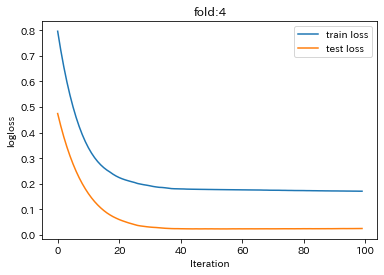

[I 2021-12-27 16:41:30,268] A new study created in memory with name: no-name-13c34b48-9933-42ec-aa89-9da5c1afa12d


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:31,219] Trial 0 finished with value: 0.40955643593482277 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.40955643593482277.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121945	Test's rmse: 0.409556
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:31,985] Trial 1 finished with value: 0.4126057279607894 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.40955643593482277.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123947	Test's rmse: 0.412606
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:32,602] Trial 2 finished with value: 0.4161325896996755 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.40955643593482277.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128394	Test's rmse: 0.416133
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:33,237] Trial 3 finished with value: 0.41682114503590617 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.40955643593482277.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123657	Test's rmse: 0.416821
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:33,781] Trial 4 finished with value: 0.38236107357140653 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 0.38236107357140653.


Early stopping, best iteration is:
[44]	Train's rmse: 0.149721	Test's rmse: 0.382361
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:34,440] Trial 5 finished with value: 0.37077356770919295 and parameters: {'feature_fraction': 1.0}. Best is trial 5 with value: 0.37077356770919295.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159528	Test's rmse: 0.370774
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:34,915] Trial 6 finished with value: 0.3805334017992264 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 0.37077356770919295.


Early stopping, best iteration is:
[37]	Train's rmse: 0.156947	Test's rmse: 0.380533
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:36,582] Trial 7 finished with value: 0.3736801139470076 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154394	Test's rmse: 0.37368
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:41:41,278] Trial 8 finished with value: 0.37449596506648225 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159027	Test's rmse: 0.374496
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:44,899] Trial 9 finished with value: 0.37449579584358833 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159028	Test's rmse: 0.374496
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:47,783] Trial 10 finished with value: 0.37449529260838316 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159029	Test's rmse: 0.374495
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:48,756] Trial 11 finished with value: 0.37517627403893855 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[31]	Train's rmse: 0.160894	Test's rmse: 0.375176
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:49,861] Trial 12 finished with value: 0.37517627403893855 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[31]	Train's rmse: 0.160894	Test's rmse: 0.375176
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:50,613] Trial 13 finished with value: 0.3740294394597813 and parameters: {'num_leaves': 16}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[30]	Train's rmse: 0.162291	Test's rmse: 0.374029
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:41:57,878] Trial 14 finished with value: 0.3744959446418685 and parameters: {'num_leaves': 222}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159027	Test's rmse: 0.374496
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:01,909] Trial 15 finished with value: 0.37449521086887144 and parameters: {'num_leaves': 155}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159029	Test's rmse: 0.374495
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:06,481] Trial 16 finished with value: 0.37449586326000056 and parameters: {'num_leaves': 182}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159028	Test's rmse: 0.374496
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:09,217] Trial 17 finished with value: 0.3736801139470076 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154394	Test's rmse: 0.37368
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:11,271] Trial 18 finished with value: 0.3737958972713638 and parameters: {'num_leaves': 98}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154606	Test's rmse: 0.373796
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:13,073] Trial 19 finished with value: 0.37449623236967217 and parameters: {'num_leaves': 91}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159063	Test's rmse: 0.374496
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:15,245] Trial 20 finished with value: 0.3736854905020465 and parameters: {'num_leaves': 104}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154428	Test's rmse: 0.373685
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:16,731] Trial 21 finished with value: 0.37373885139785085 and parameters: {'num_leaves': 68}. Best is trial 7 with value: 0.3736801139470076.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154622	Test's rmse: 0.373739
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:20,238] Trial 22 finished with value: 0.37366855958536627 and parameters: {'num_leaves': 125}. Best is trial 22 with value: 0.37366855958536627.


Early stopping, best iteration is:
[37]	Train's rmse: 0.15439	Test's rmse: 0.373669
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:23,674] Trial 23 finished with value: 0.37369419151662414 and parameters: {'num_leaves': 133}. Best is trial 22 with value: 0.37366855958536627.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154405	Test's rmse: 0.373694
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:26,050] Trial 24 finished with value: 0.3737912536638905 and parameters: {'num_leaves': 119}. Best is trial 22 with value: 0.37366855958536627.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154578	Test's rmse: 0.373791
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:27,481] Trial 25 finished with value: 0.37331250199697796 and parameters: {'num_leaves': 62}. Best is trial 25 with value: 0.37331250199697796.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154322	Test's rmse: 0.373313
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:28,875] Trial 26 finished with value: 0.37376037945144297 and parameters: {'num_leaves': 61}. Best is trial 25 with value: 0.37331250199697796.


Early stopping, best iteration is:
[37]	Train's rmse: 0.154646	Test's rmse: 0.37376
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:29,817] Trial 27 finished with value: 0.35089776559522323 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.35089776559522323.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.157784	Test's rmse: 0.350898
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:30,794] Trial 28 finished with value: 0.35307663193882205 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 27 with value: 0.35089776559522323.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152443	Test's rmse: 0.353077
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:31,794] Trial 29 finished with value: 0.35185520194696945 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 27 with value: 0.35089776559522323.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162694	Test's rmse: 0.351855
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:32,726] Trial 30 finished with value: 0.34658732627826727 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 30 with value: 0.34658732627826727.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165695	Test's rmse: 0.346587
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:33,707] Trial 31 finished with value: 0.34812616070847696 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 30 with value: 0.34658732627826727.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154516	Test's rmse: 0.348126
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:34,684] Trial 32 finished with value: 0.3530113077175857 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 30 with value: 0.34658732627826727.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167265	Test's rmse: 0.353011
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:35,627] Trial 33 finished with value: 0.3484537518827251 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 30 with value: 0.34658732627826727.


Early stopping, best iteration is:
[42]	Train's rmse: 0.173447	Test's rmse: 0.348454
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:36,672] Trial 34 finished with value: 0.34621308142483925 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 34 with value: 0.34621308142483925.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16606	Test's rmse: 0.346213
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:37,982] Trial 35 finished with value: 0.3365412327981249 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 35 with value: 0.3365412327981249.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.159617	Test's rmse: 0.336541
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:38,994] Trial 36 finished with value: 0.34083718176987726 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 35 with value: 0.3365412327981249.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161042	Test's rmse: 0.340837
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:39,999] Trial 37 finished with value: 0.3365412327981249 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.3365412327981249.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.159617	Test's rmse: 0.336541
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:41,133] Trial 38 finished with value: 0.3536551067879644 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.3365412327981249.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.157297	Test's rmse: 0.353655
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:42,448] Trial 39 finished with value: 0.3478486182012096 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.3365412327981249.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.160491	Test's rmse: 0.347849
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2021-12-27 16:42:43,827] Trial 40 finished with value: 0.34738480354870044 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.34738480354870044.


Early stopping, best iteration is:
[32]	Train's rmse: 0.193263	Test's rmse: 0.347385
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:42:44,757] Trial 41 finished with value: 0.34276748455015354 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 41 with value: 0.34276748455015354.


Early stopping, best iteration is:
[32]	Train's rmse: 0.188747	Test's rmse: 0.342767
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:45,920] Trial 42 finished with value: 0.33653838985522644 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 42 with value: 0.33653838985522644.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.159615	Test's rmse: 0.336538
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:46,874] Trial 43 finished with value: 0.34451757584040427 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 42 with value: 0.33653838985522644.


Early stopping, best iteration is:
[32]	Train's rmse: 0.189773	Test's rmse: 0.344518
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:47,786] Trial 44 finished with value: 0.3439727951820435 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 42 with value: 0.33653838985522644.


Early stopping, best iteration is:
[32]	Train's rmse: 0.188631	Test's rmse: 0.343973
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2021-12-27 16:42:48,893] Trial 45 finished with value: 0.3384730597736967 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 42 with value: 0.33653838985522644.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167694	Test's rmse: 0.338473
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:42:49,720] Trial 46 finished with value: 0.3448662230618971 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 42 with value: 0.33653838985522644.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[32]	Train's rmse: 0.188479	Test's rmse: 0.344866
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:50,816] Trial 47 finished with value: 0.3365383896238708 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 47 with value: 0.3365383896238708.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.159615	Test's rmse: 0.336538
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:51,946] Trial 48 finished with value: 0.336540429095612 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 47 with value: 0.3365383896238708.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.159622	Test's rmse: 0.33654
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:52,925] Trial 49 finished with value: 0.3439150598740525 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 47 with value: 0.3365383896238708.


Early stopping, best iteration is:
[32]	Train's rmse: 0.188591	Test's rmse: 0.343915
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:54,045] Trial 50 finished with value: 0.336546315999869 and parameters: {'lambda_l1': 7.388726219576161e-07, 'lambda_l2': 1.1323342574941946e-08}. Best is trial 47 with value: 0.3365383896238708.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.159614	Test's rmse: 0.336546
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:55,167] Trial 51 finished with value: 0.33653838715067275 and parameters: {'lambda_l1': 4.1744842423393374e-07, 'lambda_l2': 1.99371629285331e-06}. Best is trial 51 with value: 0.33653838715067275.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.159615	Test's rmse: 0.336538
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:56,023] Trial 52 finished with value: 0.3350259466453693 and parameters: {'lambda_l1': 0.0012317365144257704, 'lambda_l2': 2.077503288501903e-05}. Best is trial 52 with value: 0.3350259466453693.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160546	Test's rmse: 0.335026
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:42:57,060] Trial 53 finished with value: 0.3382361654966399 and parameters: {'lambda_l1': 0.001988245713250056, 'lambda_l2': 3.404677878190547e-05}. Best is trial 52 with value: 0.3350259466453693.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.16104	Test's rmse: 0.338236
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2021-12-27 16:42:57,561] Trial 54 finished with value: 0.3425480808340054 and parameters: {'lambda_l1': 3.3316309468938208, 'lambda_l2': 2.6087844118276602e-05}. Best is trial 52 with value: 0.3350259466453693.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:42:58,400] Trial 55 finished with value: 0.3454114016115902 and parameters: {'lambda_l1': 0.0006920448331248545, 'lambda_l2': 1.2999796199648761e-08}. Best is trial 52 with value: 0.3350259466453693.


Early stopping, best iteration is:
[31]	Train's rmse: 0.190136	Test's rmse: 0.345411
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:42:59,228] Trial 56 finished with value: 0.3432059613337942 and parameters: {'lambda_l1': 0.02540569136626575, 'lambda_l2': 3.098899358073779e-05}. Best is trial 52 with value: 0.3350259466453693.


Early stopping, best iteration is:
[32]	Train's rmse: 0.1887	Test's rmse: 0.343206
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:43:00,072] Trial 57 finished with value: 0.33623989039956165 and parameters: {'lambda_l1': 6.832767140803329e-06, 'lambda_l2': 0.009229967179936724}. Best is trial 52 with value: 0.3350259466453693.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160387	Test's rmse: 0.33624
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:43:01,118] Trial 58 finished with value: 0.343996615578893 and parameters: {'lambda_l1': 6.982496886163923e-05, 'lambda_l2': 0.03718972953040672}. Best is trial 52 with value: 0.3350259466453693.


Early stopping, best iteration is:
[32]	Train's rmse: 0.188645	Test's rmse: 0.343997
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:43:01,743] Trial 59 finished with value: 0.345417775418205 and parameters: {'lambda_l1': 1.1537527986755177e-05, 'lambda_l2': 0.006496926690400875}. Best is trial 52 with value: 0.3350259466453693.


Early stopping, best iteration is:
[31]	Train's rmse: 0.190142	Test's rmse: 0.345418
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:43:02,287] Trial 60 finished with value: 0.4315266514743725 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.4315266514743725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.213551	Test's rmse: 0.431527
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:43:02,700] Trial 61 finished with value: 0.32966314520966566 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 0.32966314520966566.


Early stopping, best iteration is:
[32]	Train's rmse: 0.145827	Test's rmse: 0.329663
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:43:03,264] Trial 62 finished with value: 0.32944402662936545 and parameters: {'min_child_samples': 25}. Best is trial 62 with value: 0.32944402662936545.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168955	Test's rmse: 0.329444
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:43:04,178] Trial 63 finished with value: 0.5149811753555266 and parameters: {'min_child_samples': 100}. Best is trial 62 with value: 0.32944402662936545.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.270245	Test's rmse: 0.514981
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352461
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:43:05,218] Trial 64 finished with value: 0.3692509016679427 and parameters: {'min_child_samples': 5}. Best is trial 62 with value: 0.32944402662936545.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0524061	Test's rmse: 0.369251


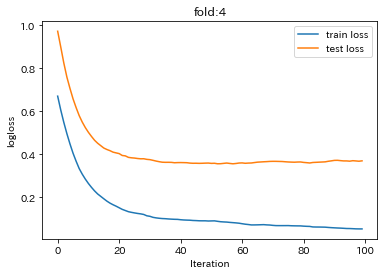

RMSE: [0.320510852394026, 0.10159232730776284, 0.13568795259606214, 0.019577429763877194, 0.3294440266293654]
RMSE: 0.1813625177382187
elapsed_time:462.7[sec]


In [10]:
# 経過時間の測定
start = time.time()

# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'deterministic':True,         # 再現性確保用のパラメータ
          'force_row_wise':True,        # 再現性確保用のパラメータ
          'seed': SEED                  # シード値
          }

best_params, history = {}, []

cv_result_quant = []

for train_index, test_index in gkf.split(X_train_ce, y_train, groups):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    model = lgb.LightGBMTuner(
                    params,                           # ハイパーパラメータをセット
                    train_set = lgb_train,            # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    show_progress_bar = False,        # ログの非表示
                    optuna_seed=SEED,
                    )
    
    # 訓練の実施
    model.run()
    
    best_params = model.best_params

   # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    best_model = model.get_best_booster()

    y_pred = best_model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_quant.append(rmse)

print("RMSE:", cv_result_quant)
print("RMSE:", np.mean(cv_result_quant))

# 経過時間の測定
elasped_time_quant = round((time.time() - start), 1)

print(f"elapsed_time:{elasped_time_quant}[sec]")

In [11]:
print("float64 RMSE:", round(np.mean(cv_result), 5))
print(f"float64 経過時間:{elasped_time}秒")

print("float16 RMSE:", round(np.mean(cv_result_quant), 5))
print(f"float16 経過時間:{elasped_time_quant}秒")

float64 RMSE: 0.18088
float64 経過時間:401.0秒
float16 RMSE: 0.18136
float16 経過時間:462.7秒
